# Logistic Regression

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os
import tqdm
from tqdm import notebook

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
PARENT = '/gdrive/MyDrive/Projects/ML_Models/'

In [4]:
%cd /gdrive/MyDrive/Projects/ML_Models/

/gdrive/MyDrive/Projects/ML_Models


In [5]:
df =  pd.read_csv('dataset_LR.csv')

In [6]:
df.head()

attr1   attr2   attr3    attr4  class
0  3.62160  8.6661 -2.8073 -0.44699      0
1  4.54590  8.1674 -2.4586 -1.46210      0
2  3.86600 -2.6383  1.9242  0.10645      0
3  3.45660  9.5228 -4.0112 -3.59440      0
4  0.32924 -4.4552  4.5718 -0.98880      0

## Model

In [52]:
class LogReg():

    def __init__(self, df, standardize=False, train_size=0.7, randomize=True):
        self.w = None
        self.b = None
        self.df = df
        self.train_size = train_size
        self.randomize = randomize
        self.standardize = standardize
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
        if standardize:
            self.standard()
    
    def train_test_split(self):
        '''
        Randomizes the data and Splits the data points into training and testing values in the ratio given.
        '''
        data = np.array(self.df)
        train_size=self.train_size
        
        if self.randomize:
            np.random.shuffle(data)

        X = data[:,:-1]
        y = data[:,-1]

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train = X[0 : train]
        X_test = X[train : train+test] 
        y_train = y[0 : train]
        y_test = y[train : train+test] 

        return X_train, X_test, y_train, y_test

    def standard(self):
        '''
        Standardizes the given data.
        '''
        self.X_train = (self.X_train - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)
        self.X_test = (self.X_test - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)  
  
    def perceptron(self, X):
        '''
        Evaluates the linear combination of the weights and the training data.
        Parameters:
            X: Training Point
        '''
        return np.dot(X, self.w.T) + self.b

    def sigmoid(self, X):
        '''
        Sigmoid Function.
        Parameters:
            X: Training Point
        '''
        return 1.0 / (1.0 + np.exp(-X))

    def grad_w(self, x, y):
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b(self, x, y):
        '''
        Calculates the gradient of x_0 value.
        Parameters:
            x: 
            y: 
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)

    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])
    
    def accuracy(self, y_pred, y):
        '''
        Calculates the accuracy score of the predicted values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        correct = 0
        for i in range(y.shape[0]):
            if y_pred[i]>0.5:
                yp=1
            else:
                yp=0
            if y[i] == yp:
                correct += 1
        return correct / float(y.shape[0])

    def fit(self, X, Y, epochs = 1, learning='GD', learning_rate = 1, batch_size=1, intialize = False, display_loss=False):
        '''
        Trains the model either using Gradient Descent or Stochastic Gradient Descent.
        Parameters:
            X: testing sample
        '''
    
        #intialize
        if intialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss={}
            accuracy={}

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if learning == 'SGD':
                # for j in range(X.shape[0]):
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)
                db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if learning == 'MBSGD':
                randInt = np.arange(0, X.shape[0], batch_size)
                np.random.shuffle(randInt)
                for j in range(randInt.shape[0]):
                    x = X[randInt[j], :]
                    y = Y[randInt[j]]
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]
                accuracy[i] = self.accuracy(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,'Loss:', loss[i],'Accuracy:', accuracy[i])

        if display_loss:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')

            plt.subplot(2, 1, 2)
            plt.plot(list(accuracy.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            
            plt.show()

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
    def binarize(self, X, threshold=0.5):
        '''
        Evaluates the binary labels of the given data.
        Parameters:
            X: testing sample
        '''
        y_pred = self.predict(X)
        Y_p = []
        for y in range(y_pred.shape[0]):
            if y_pred[y]>threshold:
                Y_p+=[1]
            else:
                Y_p+=[0]
        return np.array(Y_p)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.binarize(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)

    def cross_val(self, k, epochs=2000, learning = 'GD', learning_rate=0.015, batch_size=1):
        '''
        Performs k-fold validation on the given data.  
        Parameters:
            data
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0

        print('Total of 10 Splits:')        
        for i in range(k):
            
            print('Split', i+1,': ')
            X_train, X_test, Y_train, Y_test = self.train_test_split()  
            if self.standardize:
                self.standard()
                
            print('Training the Model...')
            self.fit(X_train, Y_train, epochs, learning=learning, learning_rate=learning_rate , intialize = True, display_loss=True, batch_size=batch_size)
            print('Trained the Model.')

            y_pred = self.binarize(X_test)            
            metric_dict = self.report(y_pred, Y_test)
            print('The most important feature is \'attr', np.argmax(self.w), '\'','with weight', self.w[0][np.argmax(self.w)])
            
            TP+=metric_dict['TP']
            TN+=metric_dict['TN']
            FP+=metric_dict['FP']
            FN+=metric_dict['FN']
            Total+=metric_dict['Total']
            accuracy+=metric_dict['Accuracy']
            precision+=metric_dict['Precision']
            recall+=metric_dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()

## Gradient Descent

### Learning Rate = 0.015 and Epochs = 300 - Accuracy = 98.78% - No Standardization

In [17]:
GD = LogReg(df)

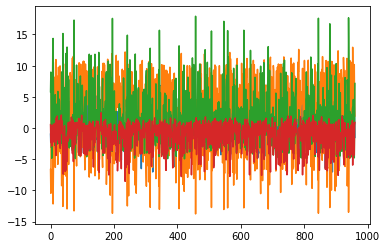

In [18]:
plt.plot(GD.X_train)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.14979708885923487 Accuracy: 0.821875
Epoch: 50 Loss: 0.010793596287493146 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.011823561899831731 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.009584580492064987 Accuracy: 0.9875
Epoch: 200 Loss: 0.009097268167660481 Accuracy: 0.9875
Epoch: 250 Loss: 0.007739893974698076 Accuracy: 0.990625



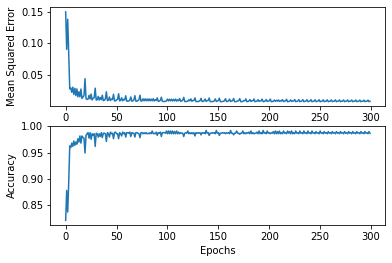

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.1824945029822651
Classification Report
                             
TP                        179
TN                        229
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall      0.988950276243094
Precision  0.9944444444444445


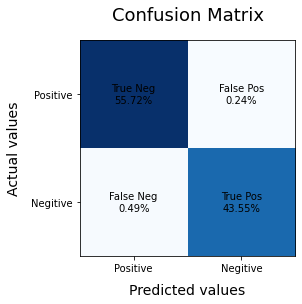

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.2280090135084348 Accuracy: 0.7229166666666667
Epoch: 50 Loss: 0.012216284644717171 Accuracy: 0.984375
Epoch: 100 Loss: 0.007537987889918494 Accuracy: 0.990625
Epoch: 150 Loss: 0.008460971780223616 Accuracy: 0.990625
Epoch: 200 Loss: 0.007439276639455037 Accuracy: 0.990625
Epoch: 250 Loss: 0.007273033568729973 Accuracy: 0.990625



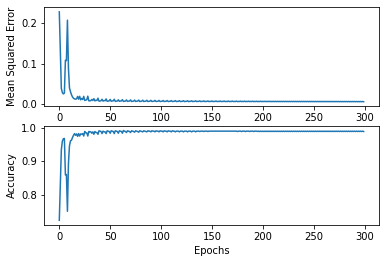

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.32422180404182055
Classification Report
                             
TP                        175
TN                        231
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9943181818181818
Precision  0.9776536312849162


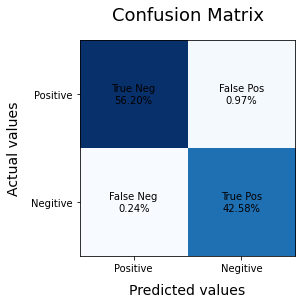

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.16928973233698072 Accuracy: 0.7583333333333333
Epoch: 50 Loss: 0.011979925882762359 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.0078084335683543905 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.007954970031190688 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.0074638850994469845 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.007166089362142204 Accuracy: 0.9895833333333334



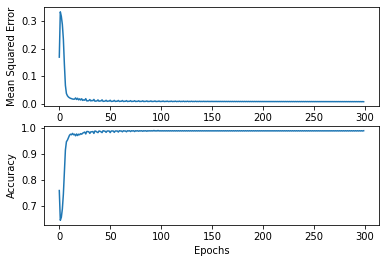

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.33646597666465855
Classification Report
                             
TP                        176
TN                        231
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9777777777777777


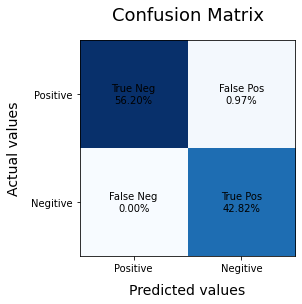

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.1403212968034932 Accuracy: 0.821875
Epoch: 50 Loss: 0.009671804660683351 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.01285269878387399 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.0071916260127368814 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007427762899516247 Accuracy: 0.990625
Epoch: 250 Loss: 0.006981049006147078 Accuracy: 0.9916666666666667



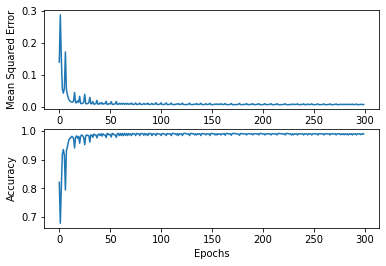

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3388170438000466
Classification Report
                             
TP                        178
TN                        228
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall      0.994413407821229
Precision   0.978021978021978


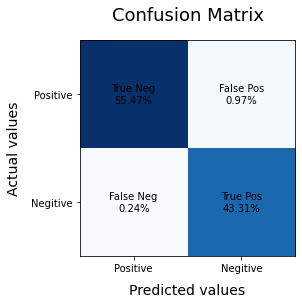

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.050764119488490085 Accuracy: 0.928125
Epoch: 50 Loss: 0.008575324746122152 Accuracy: 0.9916666666666667
Epoch: 100 Loss: 0.006643555077412123 Accuracy: 0.99375
Epoch: 150 Loss: 0.00604585044591185 Accuracy: 0.99375
Epoch: 200 Loss: 0.005727628833521155 Accuracy: 0.99375
Epoch: 250 Loss: 0.005527207358088443 Accuracy: 0.99375



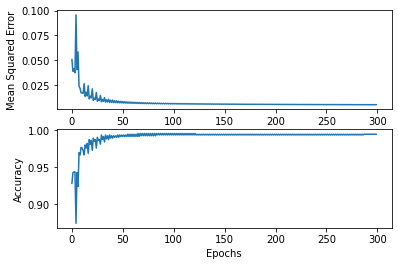

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.39726829488789034
Classification Report
                             
TP                        168
TN                        237
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9655172413793104


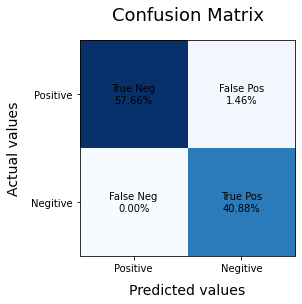

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.3470556024818297 Accuracy: 0.6291666666666667
Epoch: 50 Loss: 0.0073502317207365855 Accuracy: 0.9927083333333333
Epoch: 100 Loss: 0.006649214002574221 Accuracy: 0.99375
Epoch: 150 Loss: 0.006821979704223891 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.0064026610474042355 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.006327620013888559 Accuracy: 0.9927083333333333



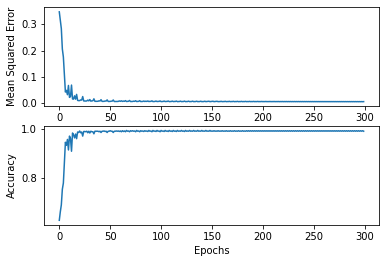

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3659813612425676
Classification Report
                             
TP                        182
TN                        223
FP                          5
FN                          1
Total                     411
Accuracy   0.9854014598540146
Recall      0.994535519125683
Precision  0.9732620320855615


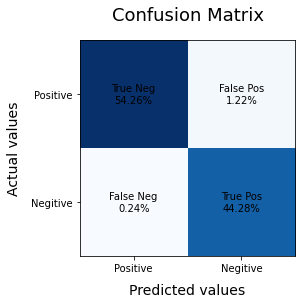

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.6255504493310713 Accuracy: 0.3072916666666667
Epoch: 50 Loss: 0.008453053065635464 Accuracy: 0.9875
Epoch: 100 Loss: 0.00932672408558354 Accuracy: 0.990625
Epoch: 150 Loss: 0.007641571948679981 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.008881778031899025 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.0099948610152949 Accuracy: 0.9854166666666667



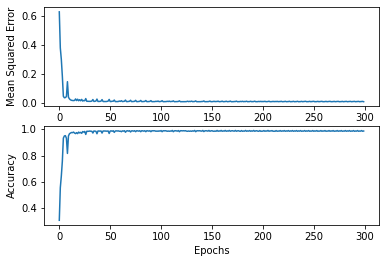

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.12959913842822957
Classification Report
                             
TP                        172
TN                        236
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall     0.9942196531791907
Precision  0.9885057471264368


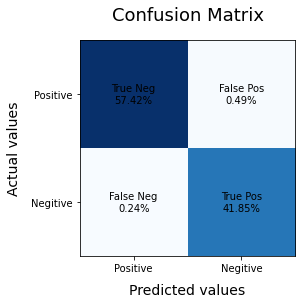

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.4147068934728028 Accuracy: 0.5416666666666666
Epoch: 50 Loss: 0.010395371764515856 Accuracy: 0.9875
Epoch: 100 Loss: 0.007148983836979275 Accuracy: 0.990625
Epoch: 150 Loss: 0.006964726519006242 Accuracy: 0.990625
Epoch: 200 Loss: 0.0063943515075854255 Accuracy: 0.990625
Epoch: 250 Loss: 0.0059669767170658075 Accuracy: 0.990625



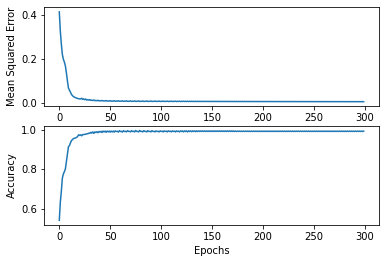

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.19613716233590656
Classification Report
                             
TP                        178
TN                        222
FP                          2
FN                          9
Total                     411
Accuracy   0.9732360097323601
Recall     0.9518716577540107
Precision  0.9888888888888889


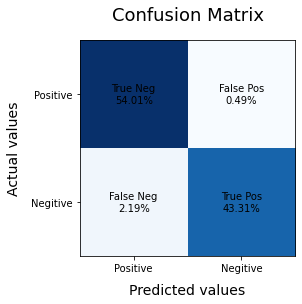

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.14770289859324276 Accuracy: 0.7885416666666667
Epoch: 50 Loss: 0.007441292153432404 Accuracy: 0.990625
Epoch: 100 Loss: 0.010734666346722434 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.008210633023254282 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.00613000207378628 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.008250549918480463 Accuracy: 0.9885416666666667



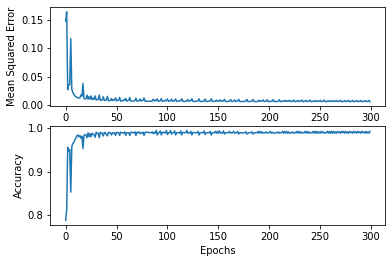

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.19525978734913638
Classification Report
                             
TP                        171
TN                        236
FP                          1
FN                          3
Total                     411
Accuracy   0.9902676399026764
Recall     0.9827586206896551
Precision  0.9941860465116279


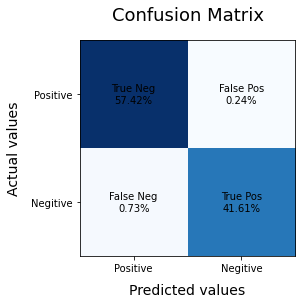

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.22899864672404385 Accuracy: 0.6833333333333333
Epoch: 50 Loss: 0.010893033682004442 Accuracy: 0.984375
Epoch: 100 Loss: 0.00845620427423879 Accuracy: 0.990625
Epoch: 150 Loss: 0.00937497340058659 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.012339957382184689 Accuracy: 0.984375
Epoch: 250 Loss: 0.010684594047405472 Accuracy: 0.9864583333333333



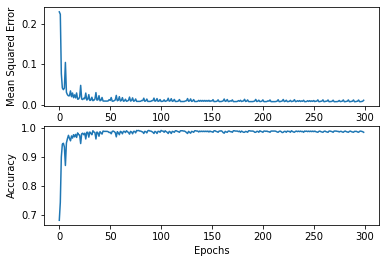

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.31903103797899024
Classification Report
                             
TP                        182
TN                        226
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall      0.994535519125683
Precision  0.9891304347826086


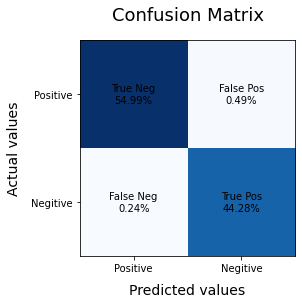

Final Classification Report
                             
TP                      176.1
TN                      229.9
FP                        3.1
FN                        1.9
Total                   411.0
Accuracy   0.9878345498783455
Recall     0.9895602835756728
Precision  0.9827388222303552


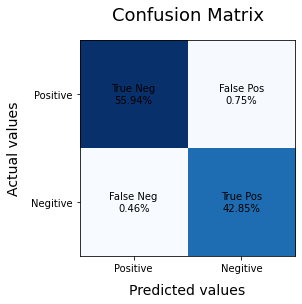

In [ ]:
GD.cross_val(10, epochs=300, learning_rate=0.015)

In [ ]:
# file = open(os.path.join(PARENT, 'GD_model_1.pickle'), 'wb')
# pickle.dump(sn, file)
# file.close()

In [ ]:
file = open(os.path.join(PARENT, 'GD_model_1.pickle'), 'rb')
GD = pickle.load(file)
file.close()

### Learning Rate = 0.1 and Epochs = 200 - Accuracy = 98.90% - Standardized

In [16]:
GD3 = LogReg(df, standardize=True)

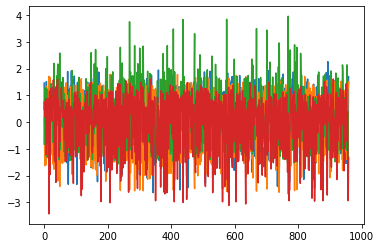

In [19]:
plt.plot(GD3.X_train)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.33459108542642724 Accuracy: 0.6645833333333333
Epoch: 50 Loss: 0.23494796300331414 Accuracy: 0.759375
Epoch: 100 Loss: 0.017718942342051076 Accuracy: 0.9802083333333333
Epoch: 150 Loss: 0.00899517236336831 Accuracy: 0.9885416666666667



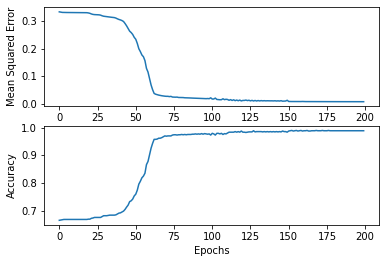

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.6777459496790401
Classification Report
                             
TP                        178
TN                        230
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9834254143646409


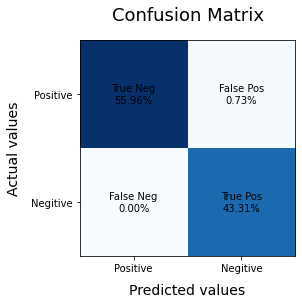

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.3128549273251283 Accuracy: 0.6854166666666667
Epoch: 50 Loss: 0.010079662716841142 Accuracy: 0.984375
Epoch: 100 Loss: 0.006043824099515325 Accuracy: 0.9916666666666667
Epoch: 150 Loss: 0.015606887213365379 Accuracy: 0.9822916666666667



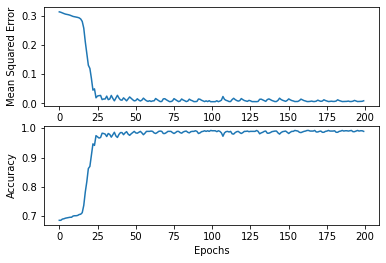

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.0441924297864693
Classification Report
                             
TP                        176
TN                        229
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9887640449438202
Precision  0.9777777777777777


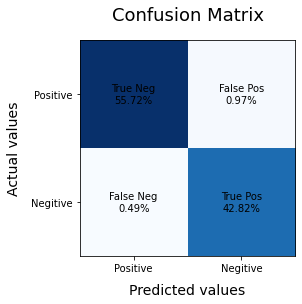

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5119227523145313 Accuracy: 0.4822916666666667
Epoch: 50 Loss: 0.020356262339052873 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.007721335007908477 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.007458471789965051 Accuracy: 0.9927083333333333



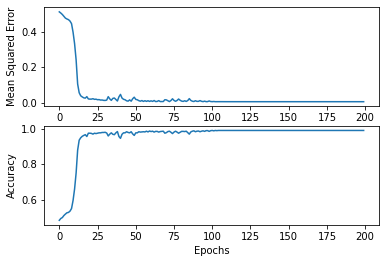

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.900128863431843
Classification Report
                             
TP                        192
TN                        216
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9846153846153847


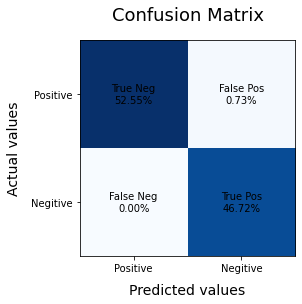

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.2683756447372539 Accuracy: 0.728125
Epoch: 50 Loss: 0.01920520001797393 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.010911014411373618 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.00652854867458703 Accuracy: 0.9927083333333333



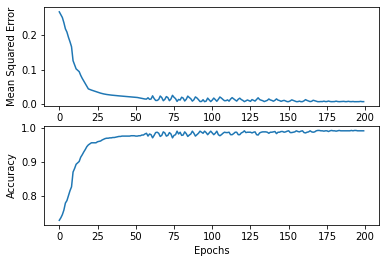

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.6782811976998002
Classification Report
                             
TP                        191
TN                        214
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9896373056994818
Precision  0.9794871794871794


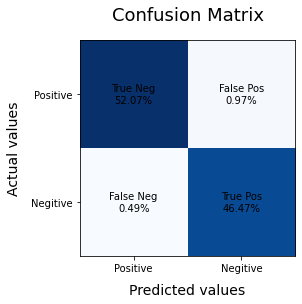

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.23932471856641485 Accuracy: 0.7427083333333333
Epoch: 50 Loss: 0.013456309587093259 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.01394676940336311 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.008265876756847486 Accuracy: 0.990625



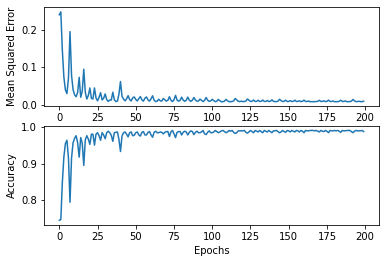

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.8267339660473938
Classification Report
                             
TP                        181
TN                        226
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9945054945054945
Precision  0.9836956521739131


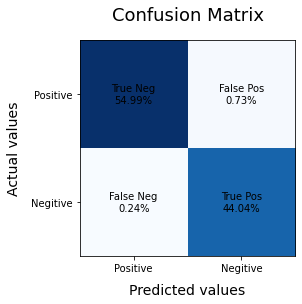

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.10480184941941391 Accuracy: 0.88125
Epoch: 50 Loss: 0.014176089118699697 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.008693715977447931 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.017347947681058462 Accuracy: 0.9802083333333333



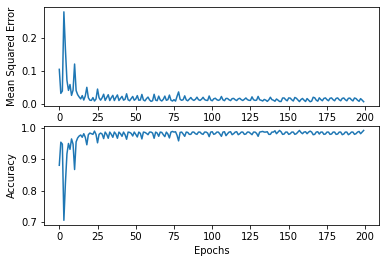

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5315766901064014
Classification Report
                             
TP                        173
TN                        234
FP                          0
FN                          4
Total                     411
Accuracy   0.9902676399026764
Recall     0.9774011299435028
Precision                 1.0


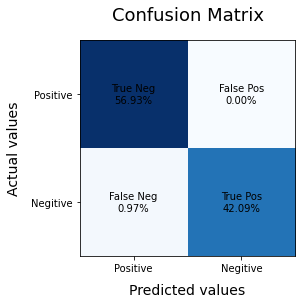

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.12710568150467125 Accuracy: 0.85
Epoch: 50 Loss: 0.004604116846823736 Accuracy: 0.9958333333333333
Epoch: 100 Loss: 0.0059956258291697425 Accuracy: 0.99375
Epoch: 150 Loss: 0.0045463333033126715 Accuracy: 0.9958333333333333



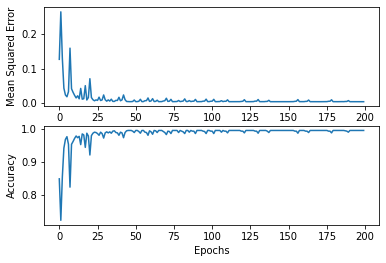

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.7235488878692222
Classification Report
                             
TP                        177
TN                        228
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9672131147540983


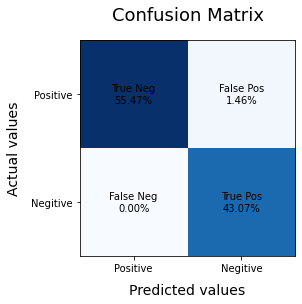

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.4781261098433564 Accuracy: 0.5125
Epoch: 50 Loss: 0.009756268069191849 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.009520331729828718 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.010082893516458417 Accuracy: 0.9875



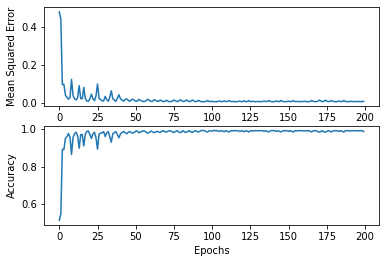

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.043653268504383
Classification Report
                             
TP                        189
TN                        217
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall     0.9895287958115183
Precision            0.984375


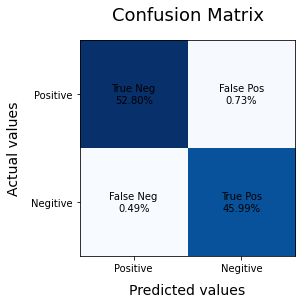

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.2773292856456279 Accuracy: 0.703125
Epoch: 50 Loss: 0.017088960962893897 Accuracy: 0.98125
Epoch: 100 Loss: 0.010491055813459467 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.00929241839995206 Accuracy: 0.9885416666666667



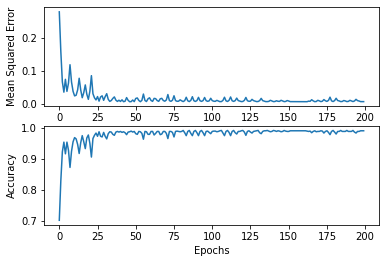

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.7980865362485733
Classification Report
                             
TP                        194
TN                        214
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9847715736040609


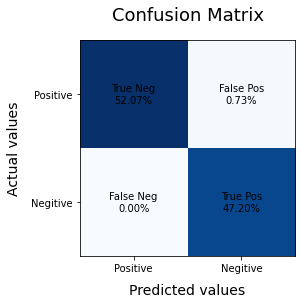

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.22669423613819892 Accuracy: 0.765625
Epoch: 50 Loss: 0.012314730041143094 Accuracy: 0.9875
Epoch: 100 Loss: 0.012108056165498822 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.00881689478676959 Accuracy: 0.990625



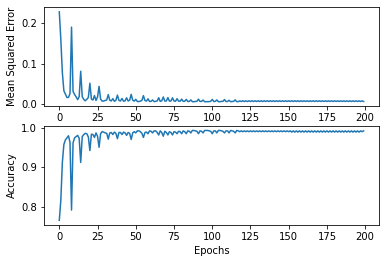

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.270233451399583
Classification Report
                             
TP                        168
TN                        238
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9940828402366864
Precision  0.9767441860465116


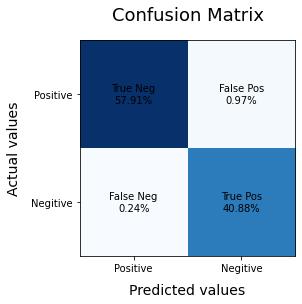

Final Classification Report
                             
TP                      181.9
TN                      224.6
FP                        3.3
FN                        1.2
Total                   411.0
Accuracy   0.9890510948905108
Recall     0.9933919611140503
Precision  0.9822105282823566


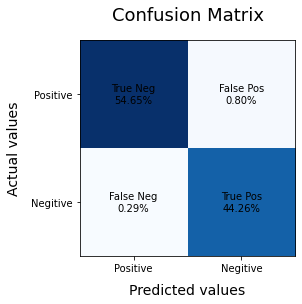

In [23]:
GD3.cross_val(10, epochs=200, learning_rate=0.1)

### Learning Rate =0.5 and Epochs = 500 - Accuracy = 99.02% - Standardized Data

In [10]:
GD1 = LogReg(df, standardize=True)

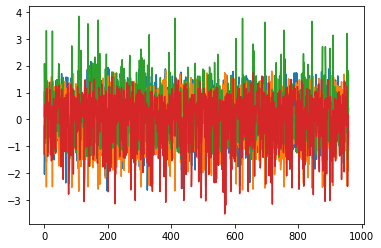

In [13]:
plt.plot(GD1.X_train)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.5073959691219728 Accuracy: 0.48854166666666665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.040004330482168546 Accuracy: 0.9583333333333334
Epoch: 100 Loss: 0.020921343560371137 Accuracy: 0.978125
Epoch: 150 Loss: 0.008329654441652882 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.011853378857123262 Accuracy: 0.9854166666666667
Epoch: 250 Loss: 0.013260766822312023 Accuracy: 0.9854166666666667
Epoch: 300 Loss: 0.02039874920595963 Accuracy: 0.9791666666666666
Epoch: 350 Loss: 0.0072960843022748835 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.007293529068100048 Accuracy: 0.9927083333333333
Epoch: 450 Loss: 0.007292938526394834 Accuracy: 0.9927083333333333



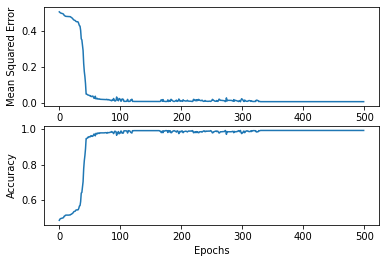

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.968972744312339
Classification Report
                             
TP                        184
TN                        224
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision   0.983957219251337


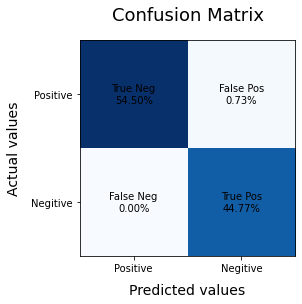

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.24589206810444247 Accuracy: 0.7510416666666667
Epoch: 50 Loss: 0.01865217361891852 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.0062743686036883265 Accuracy: 0.99375
Epoch: 150 Loss: 0.006253645292823571 Accuracy: 0.99375
Epoch: 200 Loss: 0.006253302902227816 Accuracy: 0.99375
Epoch: 250 Loss: 0.006253148880383933 Accuracy: 0.99375
Epoch: 300 Loss: 0.006253023886028519 Accuracy: 0.99375
Epoch: 350 Loss: 0.006252912825613831 Accuracy: 0.99375
Epoch: 400 Loss: 0.006252812270149567 Accuracy: 0.99375
Epoch: 450 Loss: 0.006252720484234488 Accuracy: 0.99375



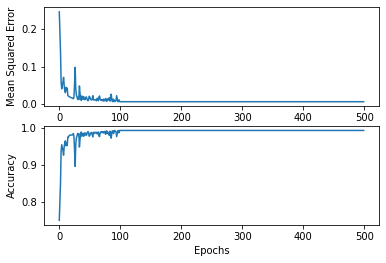

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.164275313430843
Classification Report
                             
TP                        188
TN                        219
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9791666666666666


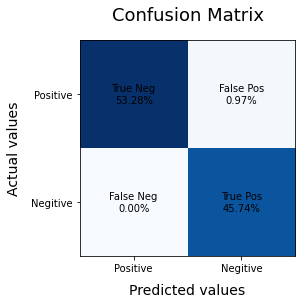

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5143864897541288 Accuracy: 0.48541666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.026464465336181315 Accuracy: 0.9729166666666667
Epoch: 100 Loss: 0.022547280441991297 Accuracy: 0.9770833333333333
Epoch: 150 Loss: 0.014993801715909737 Accuracy: 0.9833333333333333
Epoch: 200 Loss: 0.009177190607120907 Accuracy: 0.990625
Epoch: 250 Loss: 0.020902999463156276 Accuracy: 0.9791666666666666
Epoch: 300 Loss: 0.009459685910018382 Accuracy: 0.9895833333333334
Epoch: 350 Loss: 0.017078032502035934 Accuracy: 0.98125
Epoch: 400 Loss: 0.007479660662063685 Accuracy: 0.9895833333333334
Epoch: 450 Loss: 0.008466830980144663 Accuracy: 0.9875



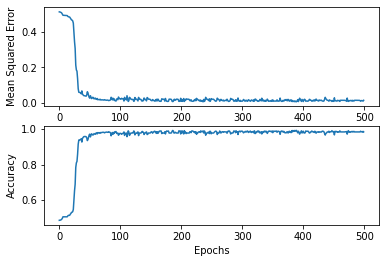

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6914639974112418
Classification Report
                             
TP                        179
TN                        228
FP                          1
FN                          3
Total                     411
Accuracy   0.9902676399026764
Recall     0.9835164835164835
Precision  0.9944444444444445


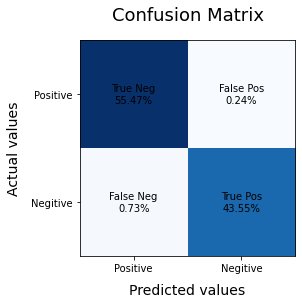

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.5192942344698188 Accuracy: 0.4791666666666667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.04343490311891266 Accuracy: 0.95625
Epoch: 100 Loss: 0.009264185962200262 Accuracy: 0.990625
Epoch: 150 Loss: 0.007790207903189753 Accuracy: 0.990625
Epoch: 200 Loss: 0.008571569665615 Accuracy: 0.990625
Epoch: 250 Loss: 0.011119589043510968 Accuracy: 0.9875
Epoch: 300 Loss: 0.00607331511590208 Accuracy: 0.99375
Epoch: 350 Loss: 0.006236492032874134 Accuracy: 0.99375
Epoch: 400 Loss: 0.006228274781934569 Accuracy: 0.99375
Epoch: 450 Loss: 0.006240414277413532 Accuracy: 0.99375



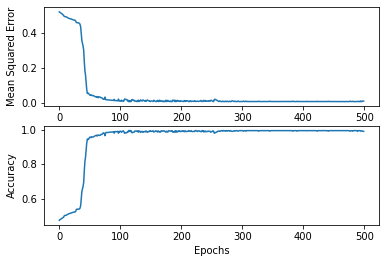

Trained the Model.
The most important feature is 'attr 3 ' with weight -2.4246301034125795
Classification Report
                             
TP                        183
TN                        222
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9891891891891892
Precision  0.9786096256684492


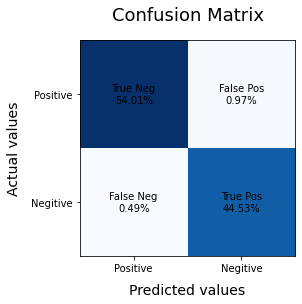

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.30885913561230904 Accuracy: 0.6885416666666667
Epoch: 50 Loss: 0.010766094650821033 Accuracy: 0.9875
Epoch: 100 Loss: 0.005218463631362596 Accuracy: 0.9947916666666666
Epoch: 150 Loss: 0.005213867833900417 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005212183336365687 Accuracy: 0.9947916666666666
Epoch: 250 Loss: 0.005211326852672964 Accuracy: 0.9947916666666666
Epoch: 300 Loss: 0.005210817109892307 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.005210484043089078 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005210252464899793 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.005210084079804776 Accuracy: 0.9947916666666666



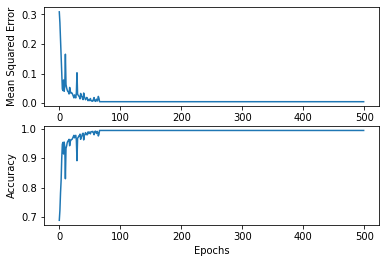

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.3583141994136865
Classification Report
                             
TP                        186
TN                        220
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9738219895287958


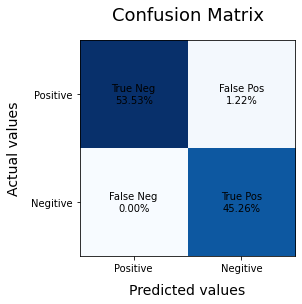

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.09098287466365022 Accuracy: 0.9
Epoch: 50 Loss: 0.020489997707597834 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.016018576347355474 Accuracy: 0.9833333333333333
Epoch: 150 Loss: 0.008334848842877591 Accuracy: 0.9916666666666667
Epoch: 200 Loss: 0.008332401153701888 Accuracy: 0.9916666666666667
Epoch: 250 Loss: 0.008330736011951773 Accuracy: 0.9916666666666667
Epoch: 300 Loss: 0.008328103923552455 Accuracy: 0.9916666666666667
Epoch: 350 Loss: 0.008312895523219234 Accuracy: 0.9916666666666667
Epoch: 400 Loss: 0.011420973950519943 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.008660207196753521 Accuracy: 0.990625



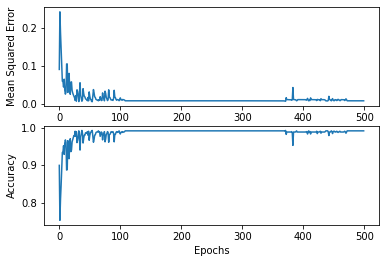

Trained the Model.
The most important feature is 'attr 3 ' with weight -3.012886103486996
Classification Report
                             
TP                        179
TN                        230
FP                          2
FN                          0
Total                     411
Accuracy   0.9951338199513382
Recall                    1.0
Precision   0.988950276243094


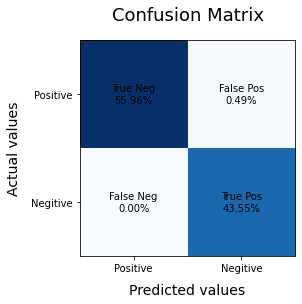

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.4941257975560196 Accuracy: 0.5041666666666667
Epoch: 50 Loss: 0.01836713548845451 Accuracy: 0.98125
Epoch: 100 Loss: 0.007301679071983868 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.00729748526450497 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.007295812506259214 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.0072949233053204825 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.007294380062875087 Accuracy: 0.9927083333333333
Epoch: 350 Loss: 0.0072940190464775385 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.00729376527266221 Accuracy: 0.9927083333333333
Epoch: 450 Loss: 0.007293579600923874 Accuracy: 0.9927083333333333



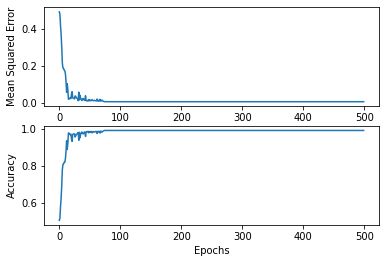

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.758281158939313
Classification Report
                             
TP                        180
TN                        228
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9836065573770492


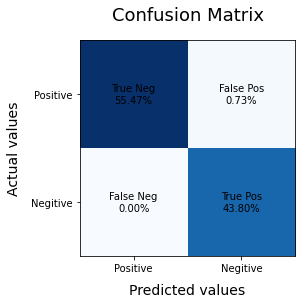

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.46842129655092474 Accuracy: 0.5302083333333333
Epoch: 50 Loss: 0.016038027365471642 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.006257454653155946 Accuracy: 0.99375
Epoch: 150 Loss: 0.006253434030838345 Accuracy: 0.99375
Epoch: 200 Loss: 0.006252738486838886 Accuracy: 0.99375
Epoch: 250 Loss: 0.006252276580843332 Accuracy: 0.99375
Epoch: 300 Loss: 0.006251947166310585 Accuracy: 0.99375
Epoch: 350 Loss: 0.006251700805516752 Accuracy: 0.99375
Epoch: 400 Loss: 0.006251509857835758 Accuracy: 0.99375
Epoch: 450 Loss: 0.006251357682093705 Accuracy: 0.99375



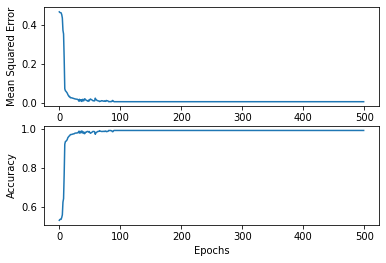

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.639230863202216
Classification Report
                             
TP                        176
TN                        230
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9943502824858758
Precision  0.9777777777777777


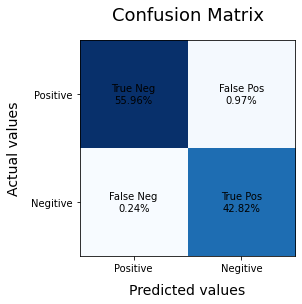

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.09451349777339317 Accuracy: 0.896875
Epoch: 50 Loss: 0.012727251441264336 Accuracy: 0.9875
Epoch: 100 Loss: 0.005221980899096801 Accuracy: 0.9947916666666666
Epoch: 150 Loss: 0.00521931695354571 Accuracy: 0.9947916666666666
Epoch: 200 Loss: 0.005217943010991336 Accuracy: 0.9947916666666666
Epoch: 250 Loss: 0.0052169785430368635 Accuracy: 0.9947916666666666
Epoch: 300 Loss: 0.005216250018874828 Accuracy: 0.9947916666666666
Epoch: 350 Loss: 0.00521568850098303 Accuracy: 0.9947916666666666
Epoch: 400 Loss: 0.005215253681489314 Accuracy: 0.9947916666666666
Epoch: 450 Loss: 0.00521491751350014 Accuracy: 0.9947916666666666



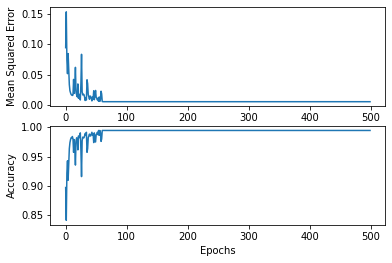

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.305826002982822
Classification Report
                             
TP                        197
TN                        209
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9752475247524752


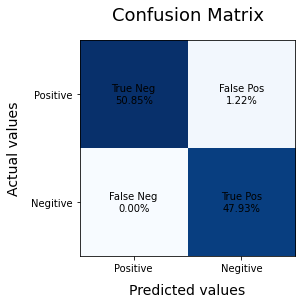

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.4978638503587875 Accuracy: 0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp


Epoch: 50 Loss: 0.029810596328198876 Accuracy: 0.9697916666666667
Epoch: 100 Loss: 0.006563412451819818 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.01425335138299355 Accuracy: 0.9854166666666667
Epoch: 200 Loss: 0.016162104762458374 Accuracy: 0.9822916666666667
Epoch: 250 Loss: 0.007236289114447307 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.018006357945391963 Accuracy: 0.9822916666666667
Epoch: 350 Loss: 0.017740157940498515 Accuracy: 0.98125
Epoch: 400 Loss: 0.01135670274159061 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.008341382332927284 Accuracy: 0.9916666666666667



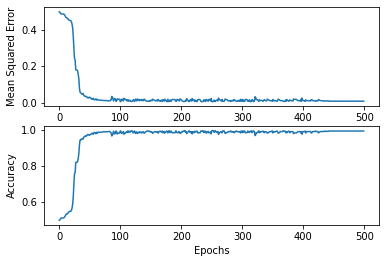

Trained the Model.
The most important feature is 'attr 3 ' with weight -4.978720323749019
Classification Report
                             
TP                        168
TN                        240
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall     0.9940828402366864
Precision  0.9882352941176471


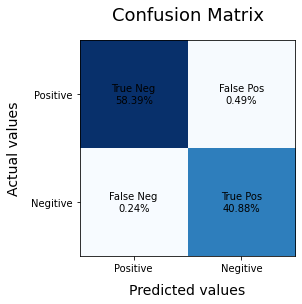

Final Classification Report
                             
TP                      182.0
TN                      225.0
FP                        3.3
FN                        0.7
Total                   411.0
Accuracy   0.9902676399026763
Recall     0.9961138795428234
Precision  0.9823817375827737


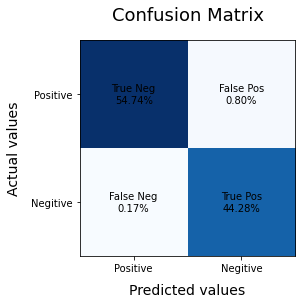

In [14]:
GD1.cross_val(10, epochs=500, learning_rate=0.5)

## Stochastic Gradient Descent

### Learning Rate = 0.015 and Epochs = 1000 - Accuracy = 70.75% - Not Standardized

In [60]:
SGD1 = LogReg(df)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.5412668932826147 Accuracy: 0.3885416666666667
Epoch: 50 Loss: 0.534393239312443 Accuracy: 0.4
Epoch: 100 Loss: 0.5190523618660968 Accuracy: 0.4270833333333333
Epoch: 150 Loss: 0.5120409067116948 Accuracy: 0.43854166666666666
Epoch: 200 Loss: 0.5071996441089913 Accuracy: 0.43854166666666666
Epoch: 250 Loss: 0.5018151346856752 Accuracy: 0.44166666666666665
Epoch: 300 Loss: 0.4976761468239352 Accuracy: 0.45
Epoch: 350 Loss: 0.49474489967849294 Accuracy: 0.453125
Epoch: 400 Loss: 0.4892923107813923 Accuracy: 0.45625
Epoch: 450 Loss: 0.48222912732590656 Accuracy: 0.4625
Epoch: 500 Loss: 0.4762677693312502 Accuracy: 0.4666666666666667
Epoch: 550 Loss: 0.46629520401318403 Accuracy: 0.475
Epoch: 600 Loss: 0.455927715629562 Accuracy: 0.48333333333333334
Epoch: 650 Loss: 0.45259936416481045 Accuracy: 0.48541666666666666
Epoch: 700 Loss: 0.444183716222835 Accuracy: 0.4875
Epoch: 750 Loss: 0.43947102121876047 Accuracy: 0.49375
Epoch: 800 Loss: 0.4243177241419097 Accuracy: 0.504166

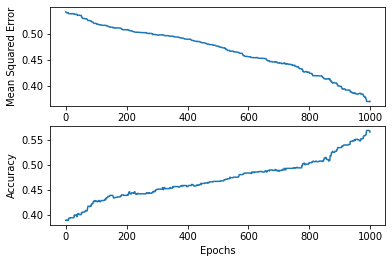

Trained the Model.
The most important feature is 'attr 2 ' with weight 1.0844610914273962
Classification Report
                             
TP                        148
TN                         74
FP                        150
FN                         39
Total                     411
Accuracy   0.5401459854014599
Recall     0.7914438502673797
Precision  0.4966442953020134


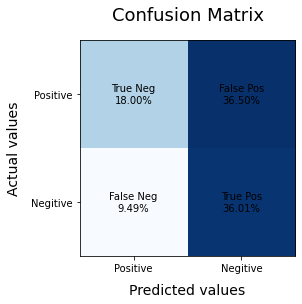

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.6536152520435399 Accuracy: 0.253125
Epoch: 50 Loss: 0.6396071630238426 Accuracy: 0.26666666666666666
Epoch: 100 Loss: 0.5783446076008656 Accuracy: 0.32395833333333335
Epoch: 150 Loss: 0.5255121294379806 Accuracy: 0.3885416666666667
Epoch: 200 Loss: 0.49601267762405965 Accuracy: 0.4375
Epoch: 250 Loss: 0.4810432874428364 Accuracy: 0.45625
Epoch: 300 Loss: 0.4737866106232278 Accuracy: 0.4708333333333333
Epoch: 350 Loss: 0.4654387052437137 Accuracy: 0.48125
Epoch: 400 Loss: 0.4617598040309324 Accuracy: 0.484375
Epoch: 450 Loss: 0.4579242388475888 Accuracy: 0.4875
Epoch: 500 Loss: 0.4514661552079389 Accuracy: 0.4947916666666667
Epoch: 550 Loss: 0.44660769639912146 Accuracy: 0.5020833333333333
Epoch: 600 Loss: 0.44176661433513387 Accuracy: 0.50625
Epoch: 650 Loss: 0.43551296746907103 Accuracy: 0.5135416666666667
Epoch: 700 Loss: 0.4285147003130452 Accuracy: 0.5135416666666667
Epoch: 750 Loss: 0.42528438992627543 Accuracy: 0.5197916666666667
Epoch: 800 Loss: 0.42309498314647

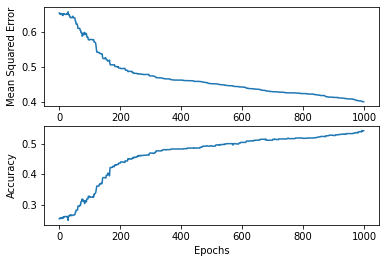

Trained the Model.
The most important feature is 'attr 3 ' with weight 1.0846761814814765
Classification Report
                             
TP                         93
TN                        150
FP                         82
FN                         86
Total                     411
Accuracy   0.5912408759124088
Recall     0.5195530726256983
Precision  0.5314285714285715


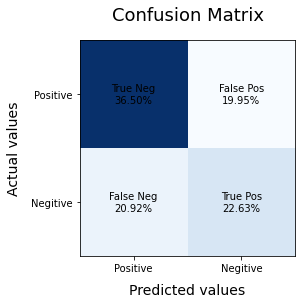

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.6454335943937329 Accuracy: 0.24270833333333333
Epoch: 50 Loss: 0.5828019223764572 Accuracy: 0.30625
Epoch: 100 Loss: 0.553549926004182 Accuracy: 0.3260416666666667
Epoch: 150 Loss: 0.5123813748254692 Accuracy: 0.36354166666666665
Epoch: 200 Loss: 0.4781442623443174 Accuracy: 0.3875
Epoch: 250 Loss: 0.41336102250353846 Accuracy: 0.45208333333333334
Epoch: 300 Loss: 0.3768839517173197 Accuracy: 0.5104166666666666
Epoch: 350 Loss: 0.33654901651068253 Accuracy: 0.5760416666666667
Epoch: 400 Loss: 0.30626882505852826 Accuracy: 0.6197916666666666
Epoch: 450 Loss: 0.28330903638691124 Accuracy: 0.6510416666666666
Epoch: 500 Loss: 0.2611760123359951 Accuracy: 0.68125
Epoch: 550 Loss: 0.23628599108690138 Accuracy: 0.709375
Epoch: 600 Loss: 0.20358662384206638 Accuracy: 0.7604166666666666
Epoch: 650 Loss: 0.19067977750669887 Accuracy: 0.7802083333333333
Epoch: 700 Loss: 0.18336970501022398 Accuracy: 0.790625
Epoch: 750 Loss: 0.17725660972725515 Accuracy: 0.8020833333333334
Epoch:

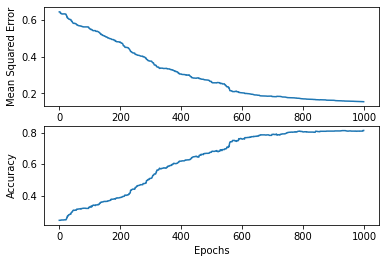

Trained the Model.
The most important feature is 'attr 3 ' with weight 1.237252963155579
Classification Report
                             
TP                        105
TN                        227
FP                          2
FN                         77
Total                     411
Accuracy   0.8077858880778589
Recall     0.5769230769230769
Precision  0.9813084112149533


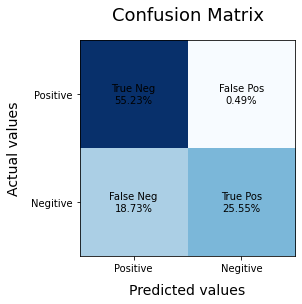

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.7060517344672391 Accuracy: 0.253125
Epoch: 50 Loss: 0.7021513125842804 Accuracy: 0.259375
Epoch: 100 Loss: 0.6974913368847305 Accuracy: 0.26666666666666666
Epoch: 150 Loss: 0.6934299551487617 Accuracy: 0.2708333333333333
Epoch: 200 Loss: 0.6906645359330669 Accuracy: 0.275
Epoch: 250 Loss: 0.6874706844564503 Accuracy: 0.278125
Epoch: 300 Loss: 0.6859870795485471 Accuracy: 0.28125
Epoch: 350 Loss: 0.6834110512282588 Accuracy: 0.28958333333333336
Epoch: 400 Loss: 0.6820251000890456 Accuracy: 0.29270833333333335
Epoch: 450 Loss: 0.681701867026775 Accuracy: 0.29375
Epoch: 500 Loss: 0.6796376963058798 Accuracy: 0.296875
Epoch: 550 Loss: 0.678346314839851 Accuracy: 0.296875
Epoch: 600 Loss: 0.6755387568110164 Accuracy: 0.3020833333333333
Epoch: 650 Loss: 0.6743521570839126 Accuracy: 0.30520833333333336
Epoch: 700 Loss: 0.6713302039516311 Accuracy: 0.3072916666666667
Epoch: 750 Loss: 0.6700916285183287 Accuracy: 0.3072916666666667
Epoch: 800 Loss: 0.6692092282852922 Accuracy: 

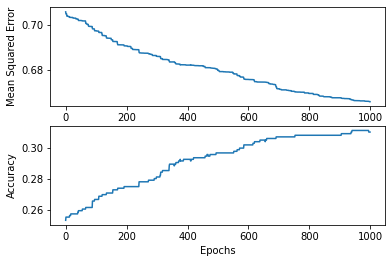

Trained the Model.
The most important feature is 'attr 1 ' with weight 1.9839046982577062
Classification Report
                              
TP                          95
TN                          52
FP                         179
FN                          85
Total                      411
Accuracy   0.35766423357664234
Recall      0.5277777777777778
Precision   0.3467153284671533


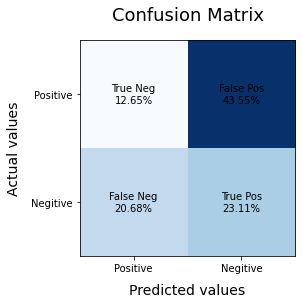

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.11102285796143459 Accuracy: 0.8416666666666667
Epoch: 50 Loss: 0.10412929620509304 Accuracy: 0.8510416666666667
Epoch: 100 Loss: 0.09572347832939386 Accuracy: 0.865625
Epoch: 150 Loss: 0.09389686556234779 Accuracy: 0.8635416666666667
Epoch: 200 Loss: 0.08364646223541004 Accuracy: 0.8802083333333334
Epoch: 250 Loss: 0.07691821423951976 Accuracy: 0.8875
Epoch: 300 Loss: 0.07117004609474381 Accuracy: 0.8916666666666667
Epoch: 350 Loss: 0.06631763688194617 Accuracy: 0.8958333333333334
Epoch: 400 Loss: 0.06405888409044147 Accuracy: 0.9010416666666666
Epoch: 450 Loss: 0.061239304211094366 Accuracy: 0.9125
Epoch: 500 Loss: 0.060480946608219156 Accuracy: 0.915625
Epoch: 550 Loss: 0.05798698801526407 Accuracy: 0.921875
Epoch: 600 Loss: 0.05676418520869238 Accuracy: 0.9229166666666667
Epoch: 650 Loss: 0.054417999068143076 Accuracy: 0.9260416666666667
Epoch: 700 Loss: 0.052864559725042594 Accuracy: 0.9260416666666667
Epoch: 750 Loss: 0.05240612294323308 Accuracy: 0.928125
Epoch: 

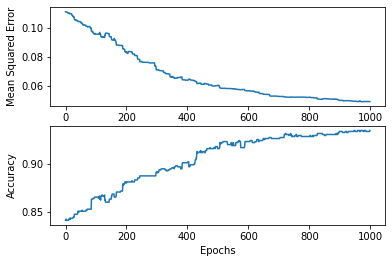

Trained the Model.
The most important feature is 'attr 2 ' with weight -0.6481725434089661
Classification Report
                            
TP                       171
TN                       210
FP                         9
FN                        21
Total                    411
Accuracy   0.927007299270073
Recall              0.890625
Precision               0.95


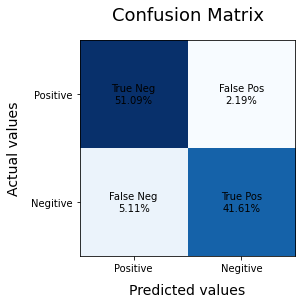

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.5447076013531059 Accuracy: 0.4239583333333333
Epoch: 50 Loss: 0.5413411483193532 Accuracy: 0.42604166666666665
Epoch: 100 Loss: 0.5357632543035451 Accuracy: 0.4322916666666667
Epoch: 150 Loss: 0.5308799862296972 Accuracy: 0.4354166666666667
Epoch: 200 Loss: 0.523018142526827 Accuracy: 0.4427083333333333
Epoch: 250 Loss: 0.5136825304230251 Accuracy: 0.45625
Epoch: 300 Loss: 0.5110756630903118 Accuracy: 0.4625
Epoch: 350 Loss: 0.5047489803278671 Accuracy: 0.4635416666666667
Epoch: 400 Loss: 0.4947463643404132 Accuracy: 0.46979166666666666
Epoch: 450 Loss: 0.4840765573516355 Accuracy: 0.4791666666666667
Epoch: 500 Loss: 0.470637222144726 Accuracy: 0.48854166666666665
Epoch: 550 Loss: 0.4438428311187945 Accuracy: 0.49270833333333336
Epoch: 600 Loss: 0.3954541031261948 Accuracy: 0.5260416666666666
Epoch: 650 Loss: 0.2939662867272275 Accuracy: 0.6239583333333333
Epoch: 700 Loss: 0.22588379010139542 Accuracy: 0.68125
Epoch: 750 Loss: 0.15512344933974428 Accuracy: 0.7854166666

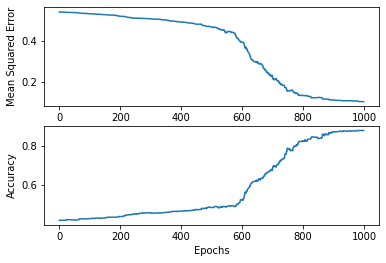

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.9560140433105525
Classification Report
                             
TP                        131
TN                        226
FP                         19
FN                         35
Total                     411
Accuracy   0.8686131386861314
Recall     0.7891566265060241
Precision  0.8733333333333333


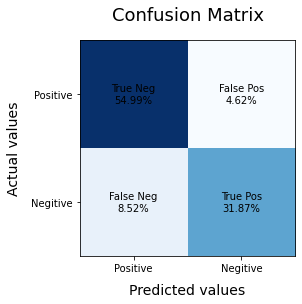

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.4807582991756308 Accuracy: 0.4635416666666667
Epoch: 50 Loss: 0.45008335018721046 Accuracy: 0.48333333333333334
Epoch: 100 Loss: 0.4062216975139952 Accuracy: 0.5208333333333334
Epoch: 150 Loss: 0.360049335620843 Accuracy: 0.5604166666666667
Epoch: 200 Loss: 0.3320002626204081 Accuracy: 0.6020833333333333
Epoch: 250 Loss: 0.3067383435853674 Accuracy: 0.6260416666666667
Epoch: 300 Loss: 0.29041544492504756 Accuracy: 0.6395833333333333
Epoch: 350 Loss: 0.25214834516897866 Accuracy: 0.6802083333333333
Epoch: 400 Loss: 0.23068484526574942 Accuracy: 0.69375
Epoch: 450 Loss: 0.19121078947326772 Accuracy: 0.7385416666666667
Epoch: 500 Loss: 0.17788087539194788 Accuracy: 0.7552083333333334
Epoch: 550 Loss: 0.16161802268001155 Accuracy: 0.7875
Epoch: 600 Loss: 0.14281298195744782 Accuracy: 0.828125
Epoch: 650 Loss: 0.14050922481320652 Accuracy: 0.821875
Epoch: 700 Loss: 0.12914650009008452 Accuracy: 0.8416666666666667
Epoch: 750 Loss: 0.12408509116189939 Accuracy: 0.845833333333

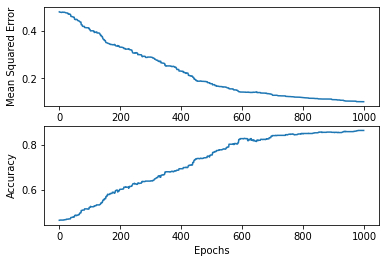

Trained the Model.
The most important feature is 'attr 2 ' with weight -0.18336034783406968
Classification Report
                             
TP                        165
TN                        185
FP                         39
FN                         22
Total                     411
Accuracy    0.851581508515815
Recall     0.8823529411764706
Precision  0.8088235294117647


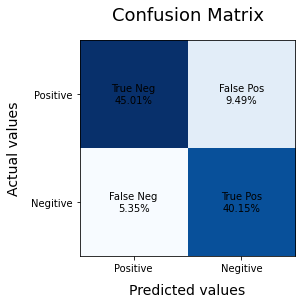

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.2658902283728301 Accuracy: 0.6520833333333333
Epoch: 50 Loss: 0.25753181193639685 Accuracy: 0.6583333333333333
Epoch: 100 Loss: 0.25125801525627156 Accuracy: 0.6708333333333333
Epoch: 150 Loss: 0.23969089738781083 Accuracy: 0.6822916666666666
Epoch: 200 Loss: 0.2271915971675065 Accuracy: 0.7020833333333333
Epoch: 250 Loss: 0.21109974960069686 Accuracy: 0.721875
Epoch: 300 Loss: 0.20257576929102222 Accuracy: 0.7354166666666667
Epoch: 350 Loss: 0.1960696076813884 Accuracy: 0.74375
Epoch: 400 Loss: 0.18881533638969009 Accuracy: 0.7510416666666667
Epoch: 450 Loss: 0.18305294662849514 Accuracy: 0.7645833333333333
Epoch: 500 Loss: 0.17773309208928606 Accuracy: 0.7708333333333334
Epoch: 550 Loss: 0.1731994831183643 Accuracy: 0.771875
Epoch: 600 Loss: 0.16520152603871668 Accuracy: 0.7822916666666667
Epoch: 650 Loss: 0.1569809161744895 Accuracy: 0.790625
Epoch: 700 Loss: 0.14946642089327036 Accuracy: 0.8083333333333333
Epoch: 750 Loss: 0.14641284700653198 Accuracy: 0.809375
Epo

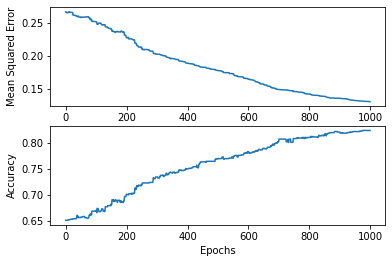

Trained the Model.
The most important feature is 'attr 2 ' with weight -0.2825884136426161
Classification Report
                             
TP                        151
TN                        189
FP                         47
FN                         24
Total                     411
Accuracy   0.8272506082725061
Recall     0.8628571428571429
Precision  0.7626262626262627


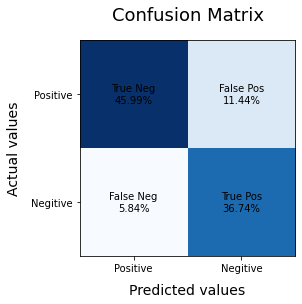

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.7461585368645418 Accuracy: 0.12708333333333333
Epoch: 50 Loss: 0.684266291508565 Accuracy: 0.1875
Epoch: 100 Loss: 0.6194317591033301 Accuracy: 0.271875
Epoch: 150 Loss: 0.5668967392276095 Accuracy: 0.31979166666666664
Epoch: 200 Loss: 0.5128684339048529 Accuracy: 0.3802083333333333
Epoch: 250 Loss: 0.490525323779311 Accuracy: 0.39895833333333336
Epoch: 300 Loss: 0.4480503402861701 Accuracy: 0.4479166666666667
Epoch: 350 Loss: 0.4287731093501075 Accuracy: 0.484375
Epoch: 400 Loss: 0.41998871518176906 Accuracy: 0.496875
Epoch: 450 Loss: 0.4048077267355985 Accuracy: 0.5
Epoch: 500 Loss: 0.3948585745367292 Accuracy: 0.50625
Epoch: 550 Loss: 0.38377385357184335 Accuracy: 0.5114583333333333
Epoch: 600 Loss: 0.36893164270692563 Accuracy: 0.5197916666666667
Epoch: 650 Loss: 0.353921759817484 Accuracy: 0.5395833333333333
Epoch: 700 Loss: 0.34148188065633833 Accuracy: 0.5520833333333334
Epoch: 750 Loss: 0.3314374199189893 Accuracy: 0.5645833333333333
Epoch: 800 Loss: 0.32056807

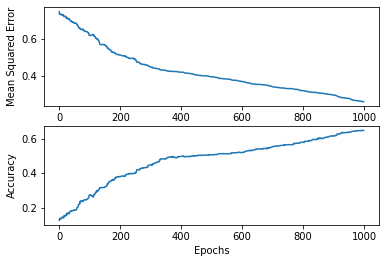

Trained the Model.
The most important feature is 'attr 0 ' with weight 0.5703156380560539
Classification Report
                             
TP                         95
TN                        166
FP                         59
FN                         91
Total                     411
Accuracy    0.635036496350365
Recall      0.510752688172043
Precision  0.6168831168831169


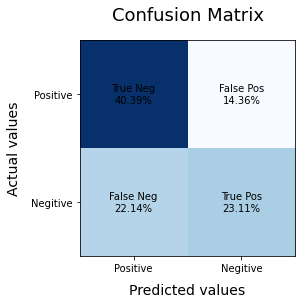

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.4663245934397631 Accuracy: 0.46041666666666664
Epoch: 50 Loss: 0.45177152987262026 Accuracy: 0.48020833333333335
Epoch: 100 Loss: 0.4358142991275207 Accuracy: 0.49166666666666664
Epoch: 150 Loss: 0.4142014717178454 Accuracy: 0.50625
Epoch: 200 Loss: 0.4072461457550588 Accuracy: 0.5125
Epoch: 250 Loss: 0.3813012062529174 Accuracy: 0.5385416666666667
Epoch: 300 Loss: 0.3483388472671768 Accuracy: 0.5770833333333333
Epoch: 350 Loss: 0.33063622316197033 Accuracy: 0.5958333333333333
Epoch: 400 Loss: 0.31901863370244765 Accuracy: 0.6125
Epoch: 450 Loss: 0.30595841737937984 Accuracy: 0.6354166666666666
Epoch: 500 Loss: 0.29975663320841706 Accuracy: 0.640625
Epoch: 550 Loss: 0.2932152554751368 Accuracy: 0.6625
Epoch: 600 Loss: 0.28841339018265694 Accuracy: 0.665625
Epoch: 650 Loss: 0.28279512402815654 Accuracy: 0.6739583333333333
Epoch: 700 Loss: 0.2747699288721851 Accuracy: 0.6822916666666666
Epoch: 750 Loss: 0.2705002537663002 Accuracy: 0.6854166666666667
Epoch: 800 Loss: 0.2

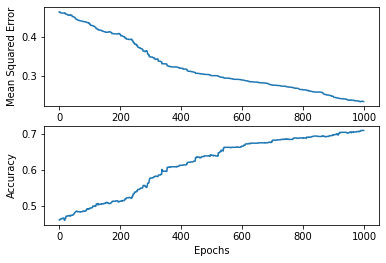

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.9535738240122815
Classification Report
                             
TP                         88
TN                        187
FP                         39
FN                         97
Total                     411
Accuracy   0.6690997566909975
Recall     0.4756756756756757
Precision  0.6929133858267716


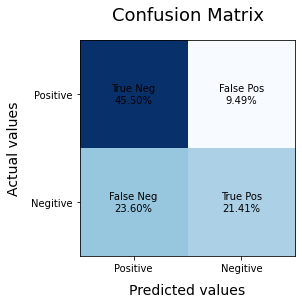

Final Classification Report
                             
TP                      124.2
TN                      166.6
FP                       62.5
FN                       57.7
Total                   411.0
Accuracy   0.7075425790754257
Recall     0.6827117851981288
Precision   0.706067623449394


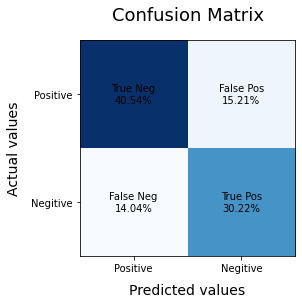

In [61]:
SGD1.cross_val(10, learning='SGD', epochs=1000, learning_rate=0.015)

### Learning Rate = 0.1 and Epochs = 1000 - Accuracy = 94.30% - Standardized

In [62]:
SGD = LogReg(df, standardize=True)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.18309529401024108 Accuracy: 0.7760416666666666
Epoch: 50 Loss: 0.15205174609652927 Accuracy: 0.8052083333333333
Epoch: 100 Loss: 0.12584263101771845 Accuracy: 0.846875
Epoch: 150 Loss: 0.09135758845249906 Accuracy: 0.8802083333333334
Epoch: 200 Loss: 0.07036620775312685 Accuracy: 0.9052083333333333
Epoch: 250 Loss: 0.060952495623089874 Accuracy: 0.915625
Epoch: 300 Loss: 0.04480462691043048 Accuracy: 0.9375
Epoch: 350 Loss: 0.040886704547605644 Accuracy: 0.9395833333333333
Epoch: 400 Loss: 0.045767136785986984 Accuracy: 0.9302083333333333
Epoch: 450 Loss: 0.031454508843753275 Accuracy: 0.9635416666666666
Epoch: 500 Loss: 0.03455917360224168 Accuracy: 0.953125
Epoch: 550 Loss: 0.029166895077598103 Accuracy: 0.9625
Epoch: 600 Loss: 0.02430462967509778 Accuracy: 0.975
Epoch: 650 Loss: 0.030717510253228983 Accuracy: 0.9583333333333334
Epoch: 700 Loss: 0.024414185495517046 Accuracy: 0.9729166666666667
Epoch: 750 Loss: 0.023972064171526603 Accuracy: 0.9708333333333333
Epoch:

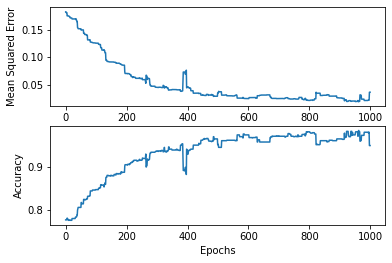

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.23818333362388808
Classification Report
                             
TP                        175
TN                        216
FP                          6
FN                         14
Total                     411
Accuracy   0.9513381995133819
Recall     0.9259259259259259
Precision  0.9668508287292817


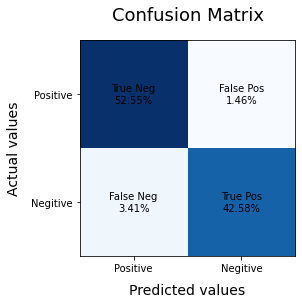

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.7912605818206714 Accuracy: 0.14479166666666668
Epoch: 50 Loss: 0.6421511681730083 Accuracy: 0.2791666666666667
Epoch: 100 Loss: 0.46131823822578 Accuracy: 0.49166666666666664
Epoch: 150 Loss: 0.43141564201043553 Accuracy: 0.521875
Epoch: 200 Loss: 0.4140633736316362 Accuracy: 0.5489583333333333
Epoch: 250 Loss: 0.39428352316435517 Accuracy: 0.5697916666666667
Epoch: 300 Loss: 0.37309490245386356 Accuracy: 0.590625
Epoch: 350 Loss: 0.3099472771872586 Accuracy: 0.6458333333333334
Epoch: 400 Loss: 0.22441223285776857 Accuracy: 0.728125
Epoch: 450 Loss: 0.18729377180741572 Accuracy: 0.79375
Epoch: 500 Loss: 0.17563205353579198 Accuracy: 0.7875
Epoch: 550 Loss: 0.1661300127232261 Accuracy: 0.79375
Epoch: 600 Loss: 0.15367859602429504 Accuracy: 0.8125
Epoch: 650 Loss: 0.08166578709869109 Accuracy: 0.8875
Epoch: 700 Loss: 0.06039569124696669 Accuracy: 0.9302083333333333
Epoch: 750 Loss: 0.05669437092787402 Accuracy: 0.9302083333333333
Epoch: 800 Loss: 0.0481455591467094 Accur

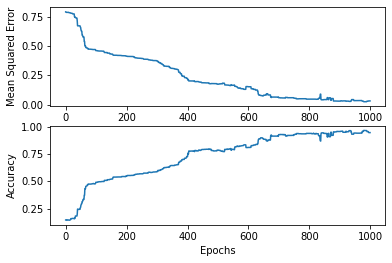

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.05578684516101777
Classification Report
                             
TP                        182
TN                        211
FP                          5
FN                         13
Total                     411
Accuracy   0.9562043795620438
Recall     0.9333333333333333
Precision  0.9732620320855615


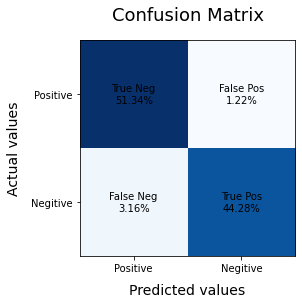

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.13664516011584713 Accuracy: 0.825
Epoch: 50 Loss: 0.04337844099952559 Accuracy: 0.9395833333333333
Epoch: 100 Loss: 0.03322088975475467 Accuracy: 0.9614583333333333
Epoch: 150 Loss: 0.030726868464102202 Accuracy: 0.9614583333333333
Epoch: 200 Loss: 0.033960466621966875 Accuracy: 0.9552083333333333
Epoch: 250 Loss: 0.030987943028771035 Accuracy: 0.9572916666666667
Epoch: 300 Loss: 0.02709618130853841 Accuracy: 0.965625
Epoch: 350 Loss: 0.026967184986588618 Accuracy: 0.9708333333333333
Epoch: 400 Loss: 0.026343689565953867 Accuracy: 0.9708333333333333
Epoch: 450 Loss: 0.022589444794498374 Accuracy: 0.9770833333333333
Epoch: 500 Loss: 0.02682745856640554 Accuracy: 0.9729166666666667
Epoch: 550 Loss: 0.022197543466828965 Accuracy: 0.9760416666666667
Epoch: 600 Loss: 0.023155912712402815 Accuracy: 0.9770833333333333
Epoch: 650 Loss: 0.020116336694669043 Accuracy: 0.978125
Epoch: 700 Loss: 0.01805719329031785 Accuracy: 0.984375
Epoch: 750 Loss: 0.017202965099929014 Accuracy:

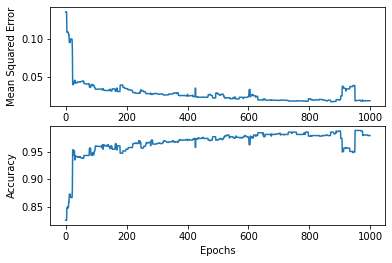

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.30239680205135855
Classification Report
                             
TP                        168
TN                        235
FP                          6
FN                          2
Total                     411
Accuracy   0.9805352798053528
Recall     0.9882352941176471
Precision  0.9655172413793104


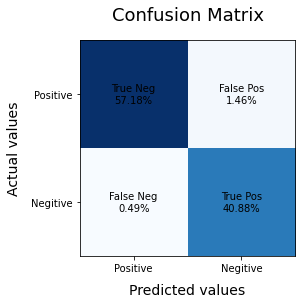

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.6367490787912059 Accuracy: 0.32708333333333334
Epoch: 50 Loss: 0.6229850359632746 Accuracy: 0.33958333333333335
Epoch: 100 Loss: 0.6016602275147809 Accuracy: 0.3489583333333333
Epoch: 150 Loss: 0.5841670017959628 Accuracy: 0.3625
Epoch: 200 Loss: 0.5476014270739811 Accuracy: 0.396875
Epoch: 250 Loss: 0.4813995506357311 Accuracy: 0.4708333333333333
Epoch: 300 Loss: 0.41582010564199023 Accuracy: 0.5177083333333333
Epoch: 350 Loss: 0.3317326281855886 Accuracy: 0.6041666666666666
Epoch: 400 Loss: 0.2373541819877571 Accuracy: 0.703125
Epoch: 450 Loss: 0.17277772619058285 Accuracy: 0.7708333333333334
Epoch: 500 Loss: 0.14618753204086882 Accuracy: 0.8125
Epoch: 550 Loss: 0.11055326987017103 Accuracy: 0.8520833333333333
Epoch: 600 Loss: 0.06335630788470453 Accuracy: 0.9041666666666667
Epoch: 650 Loss: 0.04224459575759017 Accuracy: 0.9385416666666667
Epoch: 700 Loss: 0.041348849451527975 Accuracy: 0.940625
Epoch: 750 Loss: 0.03775807229593311 Accuracy: 0.946875
Epoch: 800 Loss:

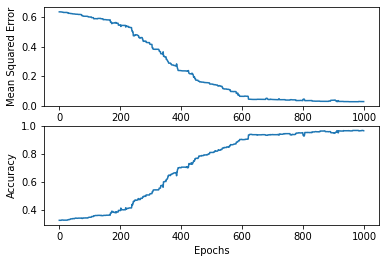

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.20370115515035903
Classification Report
                             
TP                        177
TN                        214
FP                          0
FN                         20
Total                     411
Accuracy   0.9513381995133819
Recall     0.8984771573604061
Precision                 1.0


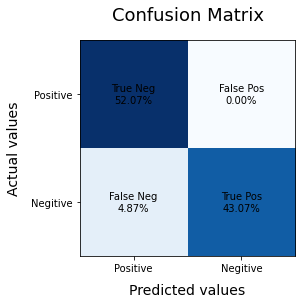

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.32288560398127486 Accuracy: 0.6
Epoch: 50 Loss: 0.2728623355605518 Accuracy: 0.6604166666666667
Epoch: 100 Loss: 0.20247554690244413 Accuracy: 0.759375
Epoch: 150 Loss: 0.18105937007433862 Accuracy: 0.7666666666666667
Epoch: 200 Loss: 0.12025668438816764 Accuracy: 0.853125
Epoch: 250 Loss: 0.09501114321446419 Accuracy: 0.8697916666666666
Epoch: 300 Loss: 0.049589364012361255 Accuracy: 0.94375
Epoch: 350 Loss: 0.03884751036467975 Accuracy: 0.959375
Epoch: 400 Loss: 0.030391354235190127 Accuracy: 0.9739583333333334
Epoch: 450 Loss: 0.02435883968970793 Accuracy: 0.9791666666666666
Epoch: 500 Loss: 0.023402719256143015 Accuracy: 0.9791666666666666
Epoch: 550 Loss: 0.022126281246147923 Accuracy: 0.9864583333333333
Epoch: 600 Loss: 0.021676186009949538 Accuracy: 0.9864583333333333
Epoch: 650 Loss: 0.01974699943680632 Accuracy: 0.978125
Epoch: 700 Loss: 0.020731419390003232 Accuracy: 0.978125
Epoch: 750 Loss: 0.023769394570733727 Accuracy: 0.96875
Epoch: 800 Loss: 0.023411994

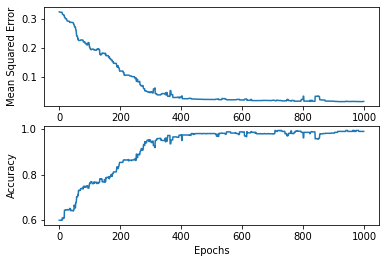

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.15394624044334873
Classification Report
                             
TP                        179
TN                        226
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9835164835164835
Precision  0.9835164835164835


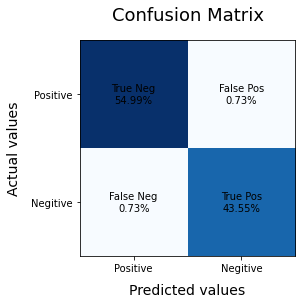

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.5145431861240997 Accuracy: 0.42083333333333334
Epoch: 50 Loss: 0.47112602766757394 Accuracy: 0.453125
Epoch: 100 Loss: 0.3913664291320828 Accuracy: 0.546875
Epoch: 150 Loss: 0.3339240719355466 Accuracy: 0.6197916666666666
Epoch: 200 Loss: 0.2813697659079658 Accuracy: 0.684375
Epoch: 250 Loss: 0.23855209990577167 Accuracy: 0.7322916666666667
Epoch: 300 Loss: 0.19947360741554743 Accuracy: 0.7822916666666667
Epoch: 350 Loss: 0.18090303178504444 Accuracy: 0.8
Epoch: 400 Loss: 0.1620864030505789 Accuracy: 0.8125
Epoch: 450 Loss: 0.10300664521287066 Accuracy: 0.8708333333333333
Epoch: 500 Loss: 0.056758710721219914 Accuracy: 0.9229166666666667
Epoch: 550 Loss: 0.03228107985679785 Accuracy: 0.9614583333333333
Epoch: 600 Loss: 0.03347382945496026 Accuracy: 0.959375
Epoch: 650 Loss: 0.01761261233498462 Accuracy: 0.9864583333333333
Epoch: 700 Loss: 0.018600026331198054 Accuracy: 0.978125
Epoch: 750 Loss: 0.018487469117518515 Accuracy: 0.9833333333333333
Epoch: 800 Loss: 0.019931

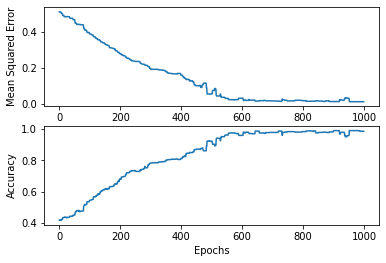

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.18531470989612983
Classification Report
                             
TP                        182
TN                        222
FP                          5
FN                          2
Total                     411
Accuracy   0.9829683698296837
Recall     0.9891304347826086
Precision  0.9732620320855615


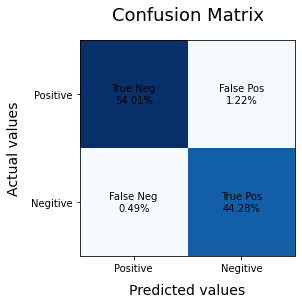

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.7693776306033127 Accuracy: 0.16458333333333333
Epoch: 50 Loss: 0.7325026886725667 Accuracy: 0.22291666666666668
Epoch: 100 Loss: 0.6705566863430739 Accuracy: 0.29375
Epoch: 150 Loss: 0.6523994864603 Accuracy: 0.325
Epoch: 200 Loss: 0.6422373184983681 Accuracy: 0.3375
Epoch: 250 Loss: 0.6329067609355186 Accuracy: 0.34375
Epoch: 300 Loss: 0.626519083563503 Accuracy: 0.34791666666666665
Epoch: 350 Loss: 0.6244591437330952 Accuracy: 0.353125
Epoch: 400 Loss: 0.6163513219567481 Accuracy: 0.35520833333333335
Epoch: 450 Loss: 0.6102522648821155 Accuracy: 0.3625
Epoch: 500 Loss: 0.6017801659829646 Accuracy: 0.371875
Epoch: 550 Loss: 0.5842106228062589 Accuracy: 0.3885416666666667
Epoch: 600 Loss: 0.5607238634797466 Accuracy: 0.41875
Epoch: 650 Loss: 0.5485005216178512 Accuracy: 0.4322916666666667
Epoch: 700 Loss: 0.5431453384371454 Accuracy: 0.434375
Epoch: 750 Loss: 0.5241379017449821 Accuracy: 0.46145833333333336
Epoch: 800 Loss: 0.5132803946253722 Accuracy: 0.46875
Epoch: 8

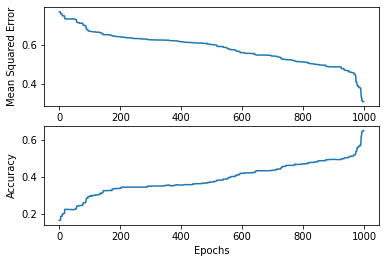

Trained the Model.
The most important feature is 'attr 3 ' with weight 1.0820213756033974
Classification Report
                             
TP                        125
TN                        157
FP                         75
FN                         54
Total                     411
Accuracy   0.6861313868613139
Recall     0.6983240223463687
Precision               0.625


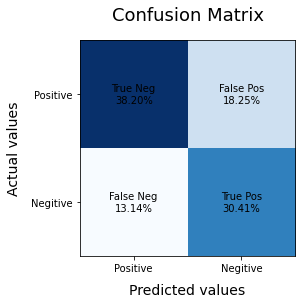

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.2923477427393165 Accuracy: 0.65625
Epoch: 50 Loss: 0.26045492287027683 Accuracy: 0.709375
Epoch: 100 Loss: 0.24774602407626975 Accuracy: 0.7270833333333333
Epoch: 150 Loss: 0.2228157354852769 Accuracy: 0.7489583333333333
Epoch: 200 Loss: 0.20280974231773413 Accuracy: 0.759375
Epoch: 250 Loss: 0.16757428073867536 Accuracy: 0.8114583333333333
Epoch: 300 Loss: 0.08249508255852964 Accuracy: 0.89375
Epoch: 350 Loss: 0.029434349428410875 Accuracy: 0.9708333333333333
Epoch: 400 Loss: 0.0219343896207325 Accuracy: 0.9822916666666667
Epoch: 450 Loss: 0.024316662449549723 Accuracy: 0.9635416666666666
Epoch: 500 Loss: 0.020408988271586225 Accuracy: 0.9833333333333333
Epoch: 550 Loss: 0.02766533196425569 Accuracy: 0.9583333333333334
Epoch: 600 Loss: 0.018518733695521556 Accuracy: 0.9864583333333333
Epoch: 650 Loss: 0.02141143013910032 Accuracy: 0.96875
Epoch: 700 Loss: 0.018358160632562966 Accuracy: 0.9875
Epoch: 750 Loss: 0.021614714079231042 Accuracy: 0.9708333333333333
Epoch: 80

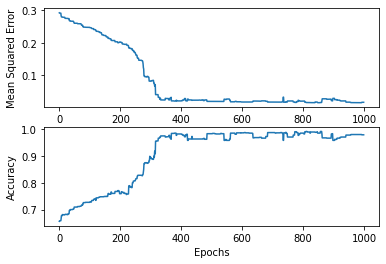

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.20703578590622962
Classification Report
                             
TP                        192
TN                        211
FP                          1
FN                          7
Total                     411
Accuracy   0.9805352798053528
Recall      0.964824120603015
Precision  0.9948186528497409


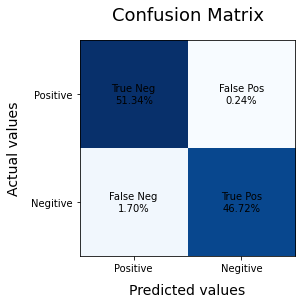

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.393343233210812 Accuracy: 0.559375
Epoch: 50 Loss: 0.38150960900052727 Accuracy: 0.5270833333333333
Epoch: 100 Loss: 0.3032340368746312 Accuracy: 0.6322916666666667
Epoch: 150 Loss: 0.25484130696828405 Accuracy: 0.6822916666666666
Epoch: 200 Loss: 0.21930113935542578 Accuracy: 0.7229166666666667
Epoch: 250 Loss: 0.148464806739233 Accuracy: 0.7958333333333333
Epoch: 300 Loss: 0.07647440300194688 Accuracy: 0.8947916666666667
Epoch: 350 Loss: 0.024562877074157153 Accuracy: 0.9822916666666667
Epoch: 400 Loss: 0.023140431719426348 Accuracy: 0.9791666666666666
Epoch: 450 Loss: 0.02347369312984336 Accuracy: 0.9791666666666666
Epoch: 500 Loss: 0.030312375825166552 Accuracy: 0.965625
Epoch: 550 Loss: 0.021116418338706235 Accuracy: 0.9854166666666667
Epoch: 600 Loss: 0.022628767095806232 Accuracy: 0.9854166666666667
Epoch: 650 Loss: 0.01993726333972939 Accuracy: 0.9875
Epoch: 700 Loss: 0.021420282076579592 Accuracy: 0.9802083333333333
Epoch: 750 Loss: 0.01914429540001523 Accurac

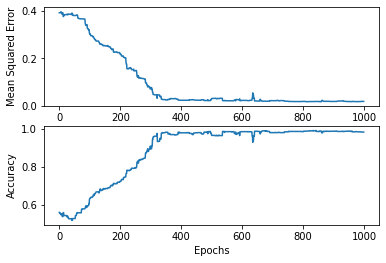

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.26156240723995927
Classification Report
                             
TP                        179
TN                        225
FP                          4
FN                          3
Total                     411
Accuracy   0.9829683698296837
Recall     0.9835164835164835
Precision  0.9781420765027322


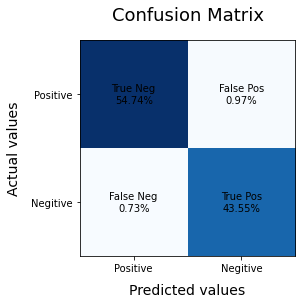

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.2378541047095952 Accuracy: 0.6822916666666666
Epoch: 50 Loss: 0.16789482310855094 Accuracy: 0.7791666666666667
Epoch: 100 Loss: 0.10917748353648744 Accuracy: 0.8708333333333333
Epoch: 150 Loss: 0.04864433829319549 Accuracy: 0.94375
Epoch: 200 Loss: 0.026340847149082015 Accuracy: 0.978125
Epoch: 250 Loss: 0.020338235849213262 Accuracy: 0.9802083333333333
Epoch: 300 Loss: 0.020558532858631667 Accuracy: 0.9770833333333333
Epoch: 350 Loss: 0.019244411498673984 Accuracy: 0.9802083333333333
Epoch: 400 Loss: 0.019266043015343844 Accuracy: 0.9791666666666666
Epoch: 450 Loss: 0.027366584748895157 Accuracy: 0.9708333333333333
Epoch: 500 Loss: 0.019734147053020522 Accuracy: 0.9791666666666666
Epoch: 550 Loss: 0.019486370559573474 Accuracy: 0.98125
Epoch: 600 Loss: 0.01794125051687551 Accuracy: 0.9822916666666667
Epoch: 650 Loss: 0.016339759250879802 Accuracy: 0.9895833333333334
Epoch: 700 Loss: 0.015781172472381373 Accuracy: 0.9895833333333334
Epoch: 750 Loss: 0.01738654878929728

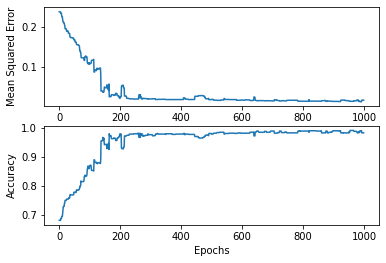

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.24312440115878647
Classification Report
                             
TP                        166
TN                        234
FP                          5
FN                          6
Total                     411
Accuracy   0.9732360097323601
Recall     0.9651162790697675
Precision  0.9707602339181286


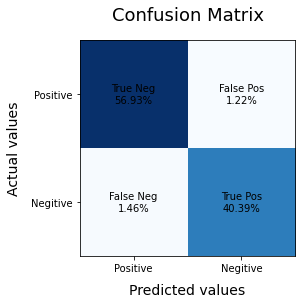

Final Classification Report
                             
TP                      172.5
TN                      215.1
FP                       11.0
FN                       12.4
Total                   411.0
Accuracy    0.943065693430657
Recall      0.933039953457204
Precision  0.9431129581066798


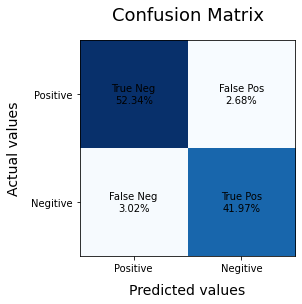

In [63]:
SGD.cross_val(10, learning='SGD', epochs=1000, learning_rate=0.1)

In [ ]:
# file = open(os.path.join(PARENT, 'SGD_model_2.pickle'), 'wb')
# pickle.dump(SGD, file)
# file.close()

In [ ]:
file = open(os.path.join(PARENT, 'SGD_model_2.pickle'), 'rb')
SGD = pickle.load(file)
file.close()

### Learning Rate = 0.5 and Epochs = 1500 - Accuracy = 96.95% - Standardized

In [64]:
SGD2 = LogReg(df, standardize=True)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.28540764925482803 Accuracy: 0.6302083333333334
Epoch: 50 Loss: 0.23113998592039106 Accuracy: 0.6875
Epoch: 100 Loss: 0.02564693827001071 Accuracy: 0.9739583333333334
Epoch: 150 Loss: 0.11144590808691282 Accuracy: 0.853125
Epoch: 200 Loss: 0.01483041164032617 Accuracy: 0.9875
Epoch: 250 Loss: 0.029337589267624985 Accuracy: 0.9645833333333333
Epoch: 300 Loss: 0.11093826209801645 Accuracy: 0.8614583333333333
Epoch: 350 Loss: 0.07285479077083086 Accuracy: 0.9
Epoch: 400 Loss: 0.01592165970116791 Accuracy: 0.9791666666666666
Epoch: 450 Loss: 0.04889668873153375 Accuracy: 0.9395833333333333
Epoch: 500 Loss: 0.014778281253535523 Accuracy: 0.9854166666666667
Epoch: 550 Loss: 0.020074478040468337 Accuracy: 0.9697916666666667
Epoch: 600 Loss: 0.015190866413947512 Accuracy: 0.98125
Epoch: 650 Loss: 0.011203497498706293 Accuracy: 0.984375
Epoch: 700 Loss: 0.01485736376189283 Accuracy: 0.9833333333333333
Epoch: 750 Loss: 0.011265646982756308 Accuracy: 0.984375
Epoch: 800 Loss: 0.01

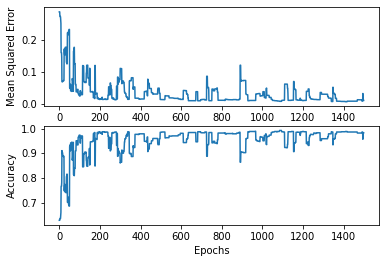

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.17351284611986537
Classification Report
                             
TP                        174
TN                        230
FP                          0
FN                          7
Total                     411
Accuracy   0.9829683698296837
Recall     0.9613259668508287
Precision                 1.0


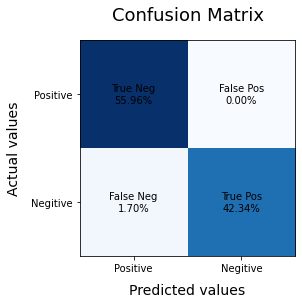

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.5469352959383232 Accuracy: 0.43333333333333335
Epoch: 50 Loss: 0.4852536882863724 Accuracy: 0.48854166666666665
Epoch: 100 Loss: 0.38517382321207627 Accuracy: 0.5604166666666667
Epoch: 150 Loss: 0.13745821172464553 Accuracy: 0.8197916666666667
Epoch: 200 Loss: 0.10654306417244037 Accuracy: 0.8645833333333334
Epoch: 250 Loss: 0.057686779533754735 Accuracy: 0.9166666666666666
Epoch: 300 Loss: 0.03391231691671257 Accuracy: 0.9520833333333333
Epoch: 350 Loss: 0.027069745825653517 Accuracy: 0.9708333333333333
Epoch: 400 Loss: 0.0184936181318015 Accuracy: 0.978125
Epoch: 450 Loss: 0.02619153188685803 Accuracy: 0.96875
Epoch: 500 Loss: 0.017179780601707217 Accuracy: 0.9791666666666666
Epoch: 550 Loss: 0.01222182142034603 Accuracy: 0.984375
Epoch: 600 Loss: 0.03874701381288634 Accuracy: 0.9416666666666667
Epoch: 650 Loss: 0.018215852159377193 Accuracy: 0.9770833333333333
Epoch: 700 Loss: 0.012293312653868928 Accuracy: 0.9833333333333333
Epoch: 750 Loss: 0.012623483165164023 Ac

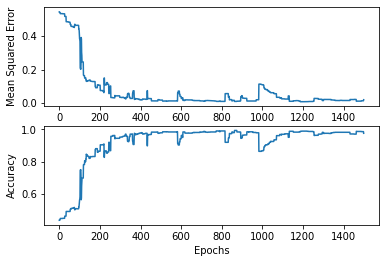

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.47558189371041093
Classification Report
                             
TP                        169
TN                        226
FP                          7
FN                          9
Total                     411
Accuracy   0.9610705596107056
Recall      0.949438202247191
Precision  0.9602272727272727


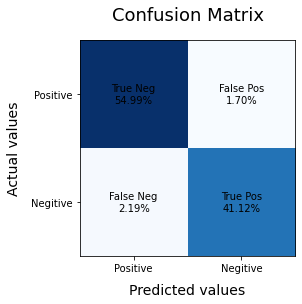

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.3700185222059798 Accuracy: 0.5770833333333333
Epoch: 50 Loss: 0.26204701056080326 Accuracy: 0.6958333333333333
Epoch: 100 Loss: 0.15536000697141666 Accuracy: 0.8125
Epoch: 150 Loss: 0.23515552794935332 Accuracy: 0.7145833333333333
Epoch: 200 Loss: 0.04909164555890088 Accuracy: 0.9354166666666667
Epoch: 250 Loss: 0.09762225214950102 Accuracy: 0.88125
Epoch: 300 Loss: 0.09011949926386982 Accuracy: 0.878125
Epoch: 350 Loss: 0.03233464339302035 Accuracy: 0.9625
Epoch: 400 Loss: 0.023905010821358774 Accuracy: 0.9697916666666667
Epoch: 450 Loss: 0.021888107504220735 Accuracy: 0.9739583333333334
Epoch: 500 Loss: 0.010450398749879184 Accuracy: 0.9885416666666667
Epoch: 550 Loss: 0.034932251706697566 Accuracy: 0.959375
Epoch: 600 Loss: 0.0317758548647333 Accuracy: 0.9552083333333333
Epoch: 650 Loss: 0.014038734022937522 Accuracy: 0.9791666666666666
Epoch: 700 Loss: 0.011606643477087683 Accuracy: 0.9833333333333333
Epoch: 750 Loss: 0.012607896155447816 Accuracy: 0.98125
Epoch: 8

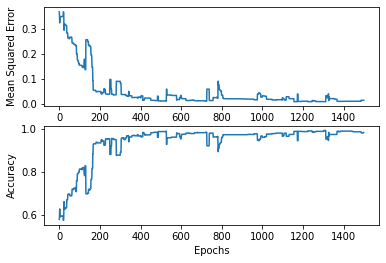

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6806989437013331
Classification Report
                             
TP                        160
TN                        244
FP                          5
FN                          2
Total                     411
Accuracy   0.9829683698296837
Recall     0.9876543209876543
Precision  0.9696969696969697


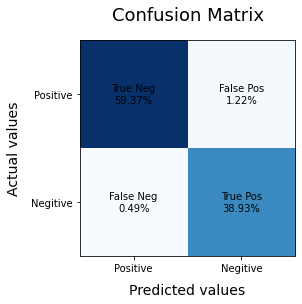

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.4330613727627376 Accuracy: 0.5260416666666666
Epoch: 50 Loss: 0.11681102946120427 Accuracy: 0.8385416666666666
Epoch: 100 Loss: 0.028464136891816354 Accuracy: 0.9645833333333333
Epoch: 150 Loss: 0.09447075245743393 Accuracy: 0.8833333333333333
Epoch: 200 Loss: 0.02590994965109342 Accuracy: 0.9614583333333333
Epoch: 250 Loss: 0.07296840665963833 Accuracy: 0.9114583333333334
Epoch: 300 Loss: 0.03469511176213026 Accuracy: 0.95625
Epoch: 350 Loss: 0.03710876393352374 Accuracy: 0.95625
Epoch: 400 Loss: 0.027886576772316908 Accuracy: 0.9645833333333333
Epoch: 450 Loss: 0.09925328761184535 Accuracy: 0.8770833333333333
Epoch: 500 Loss: 0.0339645984512389 Accuracy: 0.9572916666666667
Epoch: 550 Loss: 0.019300645968909267 Accuracy: 0.978125
Epoch: 600 Loss: 0.05224090181185844 Accuracy: 0.928125
Epoch: 650 Loss: 0.013360042278471367 Accuracy: 0.9885416666666667
Epoch: 700 Loss: 0.012025910645030002 Accuracy: 0.9916666666666667
Epoch: 750 Loss: 0.01672461009508242 Accuracy: 0.981

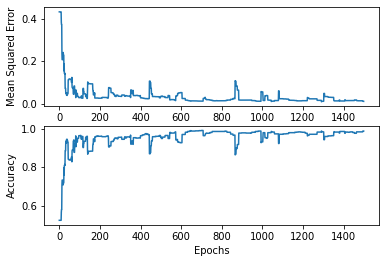

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.9449262128974818
Classification Report
                             
TP                        189
TN                        218
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9792746113989638


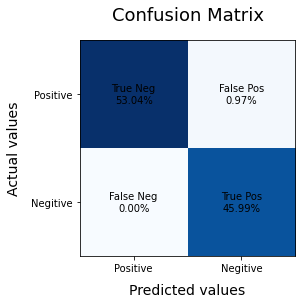

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.5811333453808649 Accuracy: 0.32083333333333336
Epoch: 50 Loss: 0.24033379120436824 Accuracy: 0.7322916666666667
Epoch: 100 Loss: 0.0986398777304775 Accuracy: 0.8770833333333333
Epoch: 150 Loss: 0.09930201715496492 Accuracy: 0.8625
Epoch: 200 Loss: 0.05284748003455648 Accuracy: 0.934375
Epoch: 250 Loss: 0.028820969892473163 Accuracy: 0.9583333333333334
Epoch: 300 Loss: 0.03133368320425607 Accuracy: 0.953125
Epoch: 350 Loss: 0.01761811366635681 Accuracy: 0.98125
Epoch: 400 Loss: 0.019475052438522298 Accuracy: 0.9802083333333333
Epoch: 450 Loss: 0.019810700263360473 Accuracy: 0.978125
Epoch: 500 Loss: 0.01759297856103425 Accuracy: 0.9770833333333333
Epoch: 550 Loss: 0.05118316079740424 Accuracy: 0.93125
Epoch: 600 Loss: 0.020562158022218145 Accuracy: 0.975
Epoch: 650 Loss: 0.02261846171117705 Accuracy: 0.9697916666666667
Epoch: 700 Loss: 0.009904083931593336 Accuracy: 0.9895833333333334
Epoch: 750 Loss: 0.03962408718555347 Accuracy: 0.95
Epoch: 800 Loss: 0.022198381895270

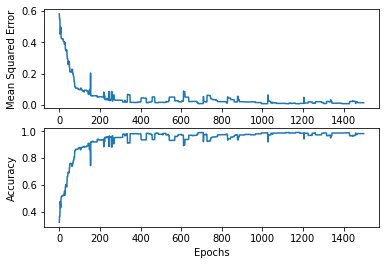

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.136884604846545
Classification Report
                             
TP                        181
TN                        223
FP                          3
FN                          4
Total                     411
Accuracy   0.9829683698296837
Recall     0.9783783783783784
Precision  0.9836956521739131


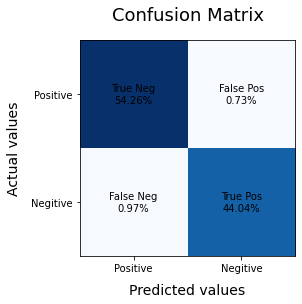

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.18730971579334213 Accuracy: 0.7020833333333333
Epoch: 50 Loss: 0.055370680733174533 Accuracy: 0.9260416666666667
Epoch: 100 Loss: 0.11364056600503372 Accuracy: 0.8552083333333333
Epoch: 150 Loss: 0.07236598497038453 Accuracy: 0.9041666666666667
Epoch: 200 Loss: 0.027321096037661616 Accuracy: 0.959375
Epoch: 250 Loss: 0.02616742250308323 Accuracy: 0.9635416666666666
Epoch: 300 Loss: 0.053397665447277504 Accuracy: 0.921875
Epoch: 350 Loss: 0.03506352057477055 Accuracy: 0.95625
Epoch: 400 Loss: 0.028908375306836587 Accuracy: 0.9604166666666667
Epoch: 450 Loss: 0.02499292662790163 Accuracy: 0.9677083333333333
Epoch: 500 Loss: 0.04481622963594175 Accuracy: 0.9395833333333333
Epoch: 550 Loss: 0.02029526319247336 Accuracy: 0.9697916666666667
Epoch: 600 Loss: 0.012968654759978231 Accuracy: 0.9833333333333333
Epoch: 650 Loss: 0.012451475369701336 Accuracy: 0.9833333333333333
Epoch: 700 Loss: 0.03208411629558117 Accuracy: 0.9510416666666667
Epoch: 750 Loss: 0.010003316283552579 

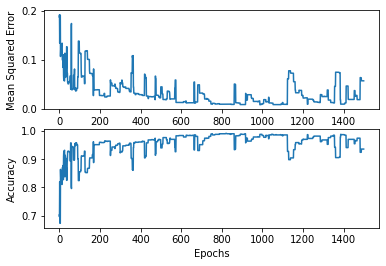

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.39232650146030396
Classification Report
                             
TP                        164
TN                        221
FP                          4
FN                         22
Total                     411
Accuracy   0.9367396593673966
Recall     0.8817204301075269
Precision  0.9761904761904762


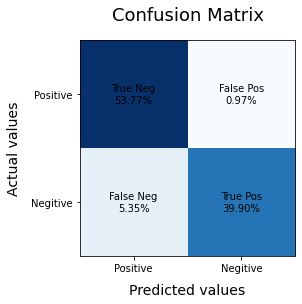

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.7373008670161249 Accuracy: 0.21354166666666666
Epoch: 50 Loss: 0.6459767239010883 Accuracy: 0.32708333333333334
Epoch: 100 Loss: 0.6026350508206922 Accuracy: 0.36770833333333336
Epoch: 150 Loss: 0.5488591646158716 Accuracy: 0.42916666666666664
Epoch: 200 Loss: 0.5001583609614685 Accuracy: 0.4822916666666667
Epoch: 250 Loss: 0.4676124836071797 Accuracy: 0.515625
Epoch: 300 Loss: 0.3886604811729831 Accuracy: 0.5770833333333333
Epoch: 350 Loss: 0.024858886166720683 Accuracy: 0.9677083333333333
Epoch: 400 Loss: 0.02806049725273281 Accuracy: 0.9604166666666667
Epoch: 450 Loss: 0.01688306120006052 Accuracy: 0.9822916666666667
Epoch: 500 Loss: 0.012426183506496713 Accuracy: 0.990625
Epoch: 550 Loss: 0.011875868376731439 Accuracy: 0.98125
Epoch: 600 Loss: 0.011517604082621572 Accuracy: 0.9833333333333333
Epoch: 650 Loss: 0.03686197065477967 Accuracy: 0.9520833333333333
Epoch: 700 Loss: 0.016482588889305778 Accuracy: 0.9739583333333334
Epoch: 750 Loss: 0.01710940474322374 Accur

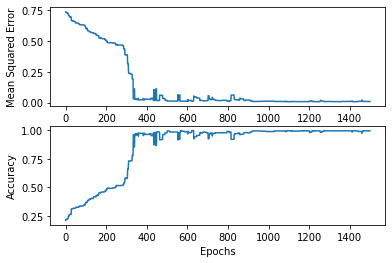

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.43920096654314056
Classification Report
                             
TP                        176
TN                        226
FP                          4
FN                          5
Total                     411
Accuracy   0.9781021897810219
Recall     0.9723756906077348
Precision  0.9777777777777777


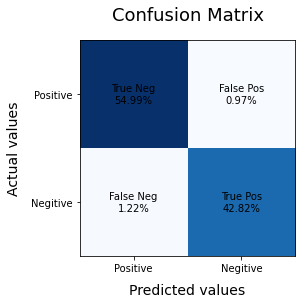

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.4552979692437612 Accuracy: 0.4739583333333333
Epoch: 50 Loss: 0.0964110061176893 Accuracy: 0.8770833333333333
Epoch: 100 Loss: 0.08211708957222792 Accuracy: 0.9
Epoch: 150 Loss: 0.09571083328360956 Accuracy: 0.8885416666666667
Epoch: 200 Loss: 0.05362433335829083 Accuracy: 0.928125
Epoch: 250 Loss: 0.052580365653358545 Accuracy: 0.921875
Epoch: 300 Loss: 0.049481226363180655 Accuracy: 0.9322916666666666
Epoch: 350 Loss: 0.0257099181300136 Accuracy: 0.9666666666666667
Epoch: 400 Loss: 0.06767045071252549 Accuracy: 0.9114583333333334
Epoch: 450 Loss: 0.06016408440091156 Accuracy: 0.921875
Epoch: 500 Loss: 0.05191188733520758 Accuracy: 0.9385416666666667
Epoch: 550 Loss: 0.08820174273951673 Accuracy: 0.89375
Epoch: 600 Loss: 0.029693431872818966 Accuracy: 0.9614583333333333
Epoch: 650 Loss: 0.024148702086353394 Accuracy: 0.9666666666666667
Epoch: 700 Loss: 0.025791905522691172 Accuracy: 0.9677083333333333
Epoch: 750 Loss: 0.022449442953523694 Accuracy: 0.9697916666666667


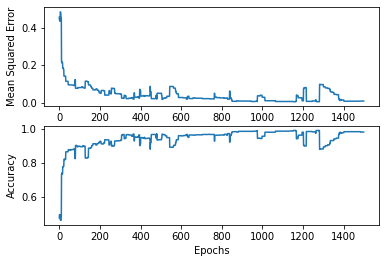

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6107463125781134
Classification Report
                             
TP                        171
TN                        227
FP                          4
FN                          9
Total                     411
Accuracy   0.9683698296836983
Recall                   0.95
Precision  0.9771428571428571


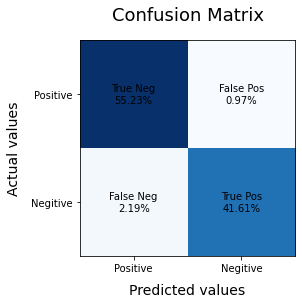

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.2984377905094885 Accuracy: 0.6552083333333333
Epoch: 50 Loss: 0.05720085598233153 Accuracy: 0.9166666666666666
Epoch: 100 Loss: 0.051886593693893174 Accuracy: 0.921875
Epoch: 150 Loss: 0.03199698961277741 Accuracy: 0.95625
Epoch: 200 Loss: 0.02416720164868162 Accuracy: 0.9645833333333333
Epoch: 250 Loss: 0.07757434795191087 Accuracy: 0.8927083333333333
Epoch: 300 Loss: 0.017720639936952158 Accuracy: 0.98125
Epoch: 350 Loss: 0.01626158080375685 Accuracy: 0.9760416666666667
Epoch: 400 Loss: 0.029368101140702655 Accuracy: 0.9635416666666666
Epoch: 450 Loss: 0.015669088166411584 Accuracy: 0.9833333333333333
Epoch: 500 Loss: 0.017387261881698975 Accuracy: 0.978125
Epoch: 550 Loss: 0.02731697387931663 Accuracy: 0.959375
Epoch: 600 Loss: 0.026112349879965035 Accuracy: 0.96875
Epoch: 650 Loss: 0.01457353791955587 Accuracy: 0.98125
Epoch: 700 Loss: 0.016133220040467668 Accuracy: 0.98125
Epoch: 750 Loss: 0.012085922698608144 Accuracy: 0.984375
Epoch: 800 Loss: 0.0111251727560528

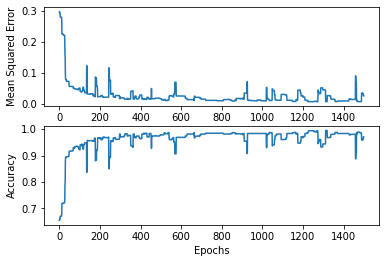

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.007979713032099456
Classification Report
                             
TP                        166
TN                        225
FP                          3
FN                         17
Total                     411
Accuracy   0.9513381995133819
Recall      0.907103825136612
Precision  0.9822485207100592


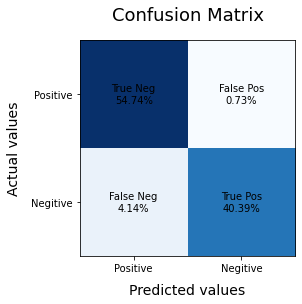

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.3480551654067543 Accuracy: 0.6291666666666667
Epoch: 50 Loss: 0.1273503867706425 Accuracy: 0.840625
Epoch: 100 Loss: 0.0337132474961992 Accuracy: 0.9510416666666667
Epoch: 150 Loss: 0.025336467743495645 Accuracy: 0.965625
Epoch: 200 Loss: 0.019038579387260873 Accuracy: 0.9802083333333333
Epoch: 250 Loss: 0.015396390729920158 Accuracy: 0.9875
Epoch: 300 Loss: 0.032131140039596745 Accuracy: 0.9541666666666667
Epoch: 350 Loss: 0.0391715933972162 Accuracy: 0.9541666666666667
Epoch: 400 Loss: 0.01621765051306044 Accuracy: 0.9822916666666667
Epoch: 450 Loss: 0.015946124875858968 Accuracy: 0.9833333333333333
Epoch: 500 Loss: 0.010072760934120944 Accuracy: 0.990625
Epoch: 550 Loss: 0.009799051698315207 Accuracy: 0.9927083333333333
Epoch: 600 Loss: 0.023559462250278565 Accuracy: 0.96875
Epoch: 650 Loss: 0.020094185674389888 Accuracy: 0.971875
Epoch: 700 Loss: 0.01665576323047852 Accuracy: 0.9802083333333333
Epoch: 750 Loss: 0.04379876119446476 Accuracy: 0.9375
Epoch: 800 Loss: 

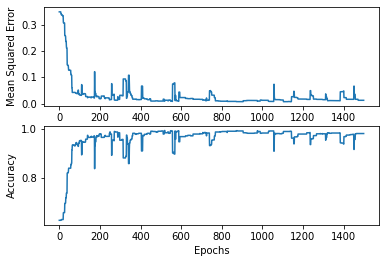

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.7478586583020488
Classification Report
                             
TP                        164
TN                        231
FP                         13
FN                          3
Total                     411
Accuracy   0.9610705596107056
Recall     0.9820359281437125
Precision  0.9265536723163842


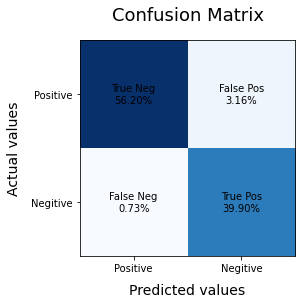

Final Classification Report
                             
TP                      171.4
TN                      227.1
FP                        4.7
FN                        7.8
Total                   411.0
Accuracy   0.9695863746958638
Recall      0.957003274245964
Precision  0.9732807810134674


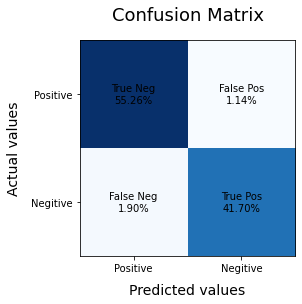

In [65]:
SGD2.cross_val(10, learning='SGD', epochs=1500, learning_rate=0.5)

### Implementing SGD with MBSGD with batch size=1

In [57]:
trial1= LogReg(df, standardize=True)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.24417811489238928 Accuracy: 0.6989583333333333
Epoch: 50 Loss: 0.010896961354978906 Accuracy: 0.984375
Epoch: 100 Loss: 0.007478446082515539 Accuracy: 0.990625



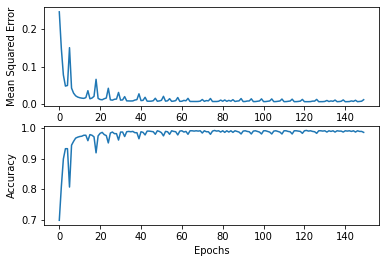

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.25108715443682106
Classification Report
                             
TP                        177
TN                        229
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall     0.9888268156424581
Precision  0.9833333333333333


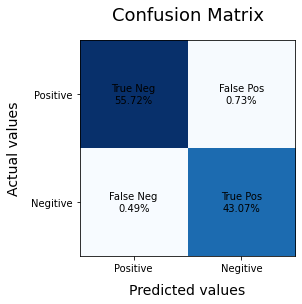

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.2859186171820436 Accuracy: 0.675
Epoch: 50 Loss: 0.0076310595018768005 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.0069912065657745485 Accuracy: 0.9927083333333333



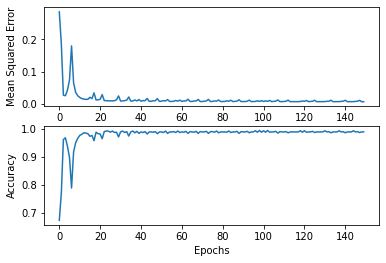

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.23592177812862947
Classification Report
                             
TP                        187
TN                        219
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall     0.9894179894179894
Precision  0.9842105263157894


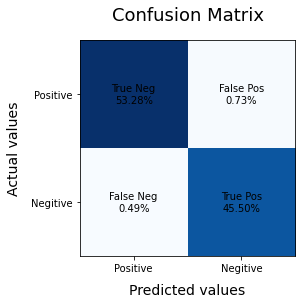

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5444943898155822 Accuracy: 0.4010416666666667
Epoch: 50 Loss: 0.008745900671250665 Accuracy: 0.9875
Epoch: 100 Loss: 0.012327249758258123 Accuracy: 0.9854166666666667



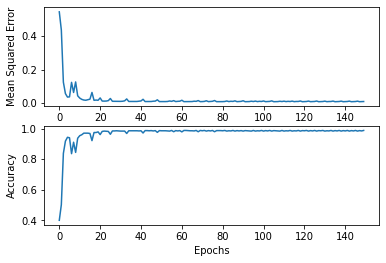

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.22758722613206342
Classification Report
                             
TP                        171
TN                        236
FP                          1
FN                          3
Total                     411
Accuracy   0.9902676399026764
Recall     0.9827586206896551
Precision  0.9941860465116279


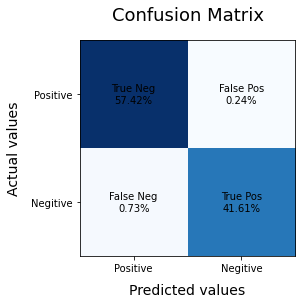

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.5278205376286399 Accuracy: 0.42291666666666666
Epoch: 50 Loss: 0.009892244730504105 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.007502088749177933 Accuracy: 0.9885416666666667



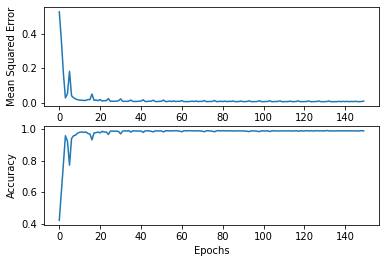

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.26614193154361315
Classification Report
                             
TP                        186
TN                        218
FP                          3
FN                          4
Total                     411
Accuracy   0.9829683698296837
Recall     0.9789473684210527
Precision  0.9841269841269841


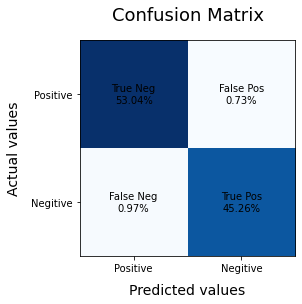

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.22653915622296156 Accuracy: 0.7458333333333333
Epoch: 50 Loss: 0.008254214765221363 Accuracy: 0.9875
Epoch: 100 Loss: 0.007063331266328729 Accuracy: 0.9885416666666667



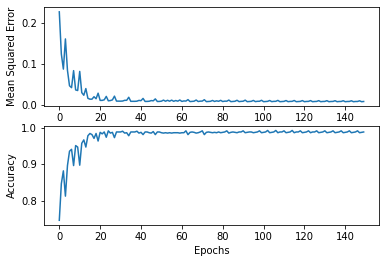

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.2489831278755357
Classification Report
                             
TP                        187
TN                        218
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9842105263157894
Precision  0.9842105263157894


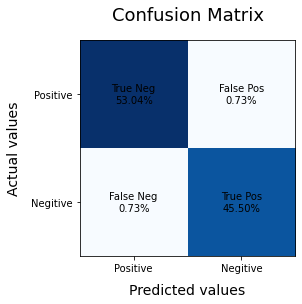

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.332606683115482 Accuracy: 0.6135416666666667
Epoch: 50 Loss: 0.013941431539797763 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.011592480753043151 Accuracy: 0.9833333333333333



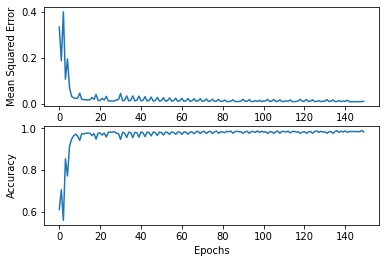

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.21485238635446519
Classification Report
              
TP         190
TN         221
FP           0
FN           0
Total      411
Accuracy   1.0
Recall     1.0
Precision  1.0


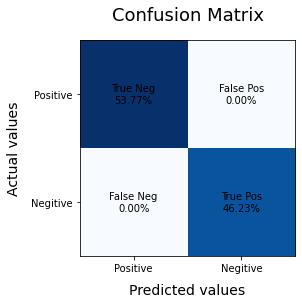

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.595913580985968 Accuracy: 0.37916666666666665
Epoch: 50 Loss: 0.011316787272159519 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.008579308018656081 Accuracy: 0.9875



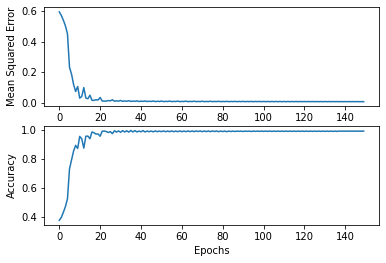

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.054206531804405066
Classification Report
                             
TP                        184
TN                        222
FP                          1
FN                          4
Total                     411
Accuracy   0.9878345498783455
Recall     0.9787234042553191
Precision  0.9945945945945946


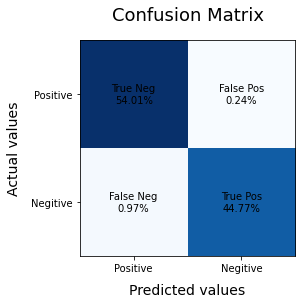

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.31760480317957374 Accuracy: 0.6302083333333334
Epoch: 50 Loss: 0.007441653740035897 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.00704396593581597 Accuracy: 0.9885416666666667



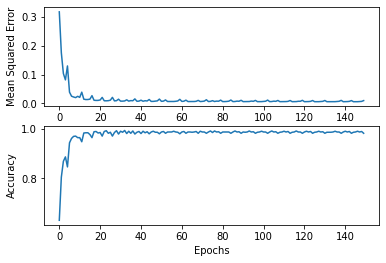

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.21652563398529975
Classification Report
                             
TP                        185
TN                        218
FP                          2
FN                          6
Total                     411
Accuracy   0.9805352798053528
Recall     0.9685863874345549
Precision  0.9893048128342246


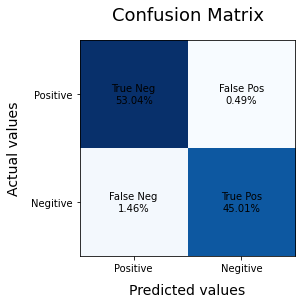

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.5931835650644545 Accuracy: 0.37395833333333334
Epoch: 50 Loss: 0.01151101829855536 Accuracy: 0.9854166666666667
Epoch: 100 Loss: 0.008022146546285337 Accuracy: 0.9875



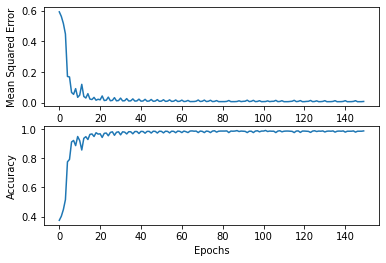

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.23205565747579418
Classification Report
                             
TP                        177
TN                        231
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall     0.9888268156424581
Precision  0.9943820224719101


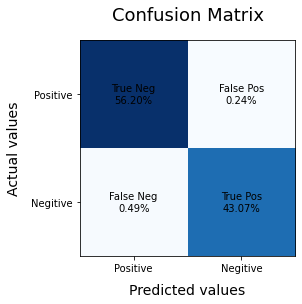

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.3039582046133766 Accuracy: 0.6677083333333333
Epoch: 50 Loss: 0.007316531342805978 Accuracy: 0.990625
Epoch: 100 Loss: 0.006984248232229455 Accuracy: 0.990625



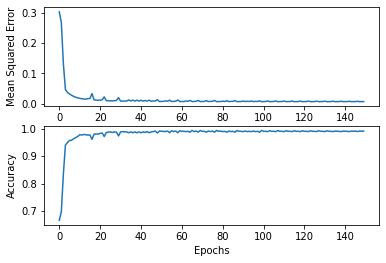

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.36424143009396487
Classification Report
                             
TP                        188
TN                        218
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9740932642487047


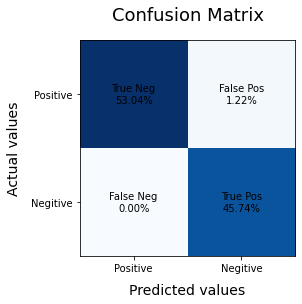

Final Classification Report
                             
TP                      183.2
TN                      223.0
FP                        2.2
FN                        2.6
Total                   411.0
Accuracy   0.9883211678832117
Recall     0.9860297927819277
Precision  0.9882442110752958


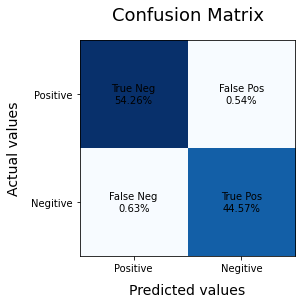

In [59]:
trial1.cross_val(10, learning='MBSGD', epochs=150, learning_rate=0.015, batch_size=1)

## Mini Batch Schoastic Gradient Descent

### Learning Rate = 0.015, Epochs = 500, Batch_size = 10 - Accuracy = 98.15% - Not Standardized

In [53]:
MBSGD = LogReg(df)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.3614884292607538 Accuracy: 0.61875
Epoch: 50 Loss: 0.05039432153193437 Accuracy: 0.9291666666666667
Epoch: 100 Loss: 0.033212398431830374 Accuracy: 0.953125
Epoch: 150 Loss: 0.02678243206580044 Accuracy: 0.9677083333333333
Epoch: 200 Loss: 0.024385178545068203 Accuracy: 0.971875
Epoch: 250 Loss: 0.024760440469995322 Accuracy: 0.9739583333333334
Epoch: 300 Loss: 0.027483188631150755 Accuracy: 0.9708333333333333
Epoch: 350 Loss: 0.029990245237942012 Accuracy: 0.96875
Epoch: 400 Loss: 0.031072563203213048 Accuracy: 0.9708333333333333
Epoch: 450 Loss: 0.03162480030674782 Accuracy: 0.9677083333333333



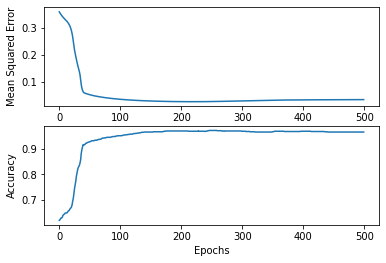

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3861715249241046
Classification Report
                             
TP                        187
TN                        209
FP                         14
FN                          1
Total                     411
Accuracy   0.9635036496350365
Recall     0.9946808510638298
Precision  0.9303482587064676


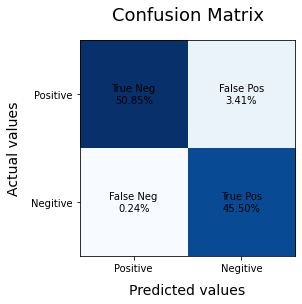

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.6272342662354942 Accuracy: 0.28958333333333336
Epoch: 50 Loss: 0.05660466046114577 Accuracy: 0.925
Epoch: 100 Loss: 0.016060500308150885 Accuracy: 0.9833333333333333
Epoch: 150 Loss: 0.013770692199429618 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.01278682406192925 Accuracy: 0.9885416666666667
Epoch: 250 Loss: 0.01227463057912447 Accuracy: 0.9895833333333334
Epoch: 300 Loss: 0.01197536569498462 Accuracy: 0.9885416666666667
Epoch: 350 Loss: 0.011783610669048927 Accuracy: 0.990625
Epoch: 400 Loss: 0.011650607791537187 Accuracy: 0.9875
Epoch: 450 Loss: 0.011551950760824948 Accuracy: 0.9875



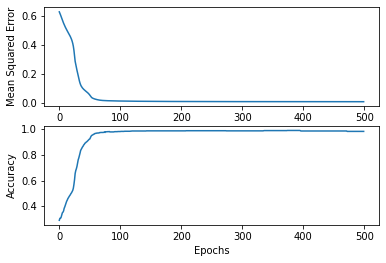

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.2626412028643541
Classification Report
                             
TP                        171
TN                        233
FP                          6
FN                          1
Total                     411
Accuracy   0.9829683698296837
Recall     0.9941860465116279
Precision  0.9661016949152542


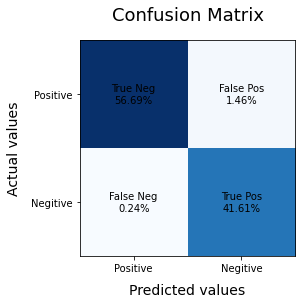

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.5896416174871385 Accuracy: 0.32916666666666666
Epoch: 50 Loss: 0.026426349741234024 Accuracy: 0.9739583333333334
Epoch: 100 Loss: 0.022381629918089188 Accuracy: 0.971875
Epoch: 150 Loss: 0.020851323344622533 Accuracy: 0.9760416666666667
Epoch: 200 Loss: 0.020085023670418388 Accuracy: 0.9770833333333333
Epoch: 250 Loss: 0.019665721718412126 Accuracy: 0.978125
Epoch: 300 Loss: 0.019430006465998902 Accuracy: 0.978125
Epoch: 350 Loss: 0.019300319110502995 Accuracy: 0.978125
Epoch: 400 Loss: 0.019235506374180266 Accuracy: 0.978125
Epoch: 450 Loss: 0.01921201381553416 Accuracy: 0.9770833333333333



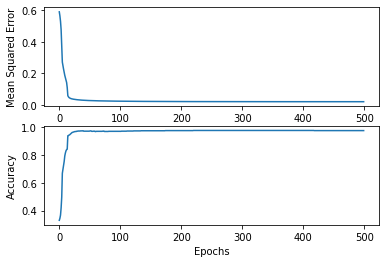

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3798870053317978
Classification Report
                             
TP                        189
TN                        217
FP                          5
FN                          0
Total                     411
Accuracy   0.9878345498783455
Recall                    1.0
Precision  0.9742268041237113


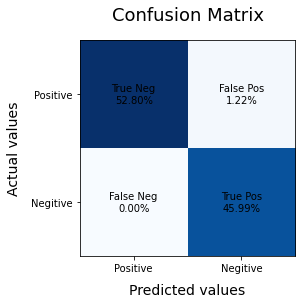

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.15409583156830473 Accuracy: 0.8083333333333333
Epoch: 50 Loss: 0.017551240758572246 Accuracy: 0.9822916666666667
Epoch: 100 Loss: 0.013368866729670876 Accuracy: 0.9885416666666667
Epoch: 150 Loss: 0.012369920638270714 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.011758183343320312 Accuracy: 0.9885416666666667
Epoch: 250 Loss: 0.011325815671975357 Accuracy: 0.9885416666666667
Epoch: 300 Loss: 0.011024891975967344 Accuracy: 0.9885416666666667
Epoch: 350 Loss: 0.010813507637031958 Accuracy: 0.9885416666666667
Epoch: 400 Loss: 0.010662370186678509 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.010552524654083436 Accuracy: 0.9885416666666667



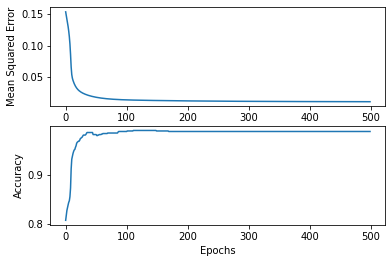

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.02279454430981477
Classification Report
                             
TP                        179
TN                        223
FP                          9
FN                          0
Total                     411
Accuracy   0.9781021897810219
Recall                    1.0
Precision  0.9521276595744681


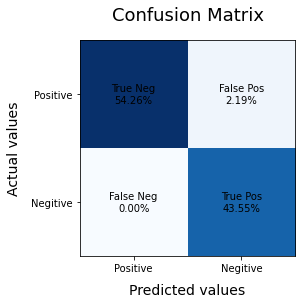

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.5514250977903052 Accuracy: 0.396875
Epoch: 50 Loss: 0.3335472997583587 Accuracy: 0.640625
Epoch: 100 Loss: 0.02921168208125109 Accuracy: 0.96875
Epoch: 150 Loss: 0.022039203958484983 Accuracy: 0.9833333333333333
Epoch: 200 Loss: 0.02033116751371877 Accuracy: 0.9760416666666667
Epoch: 250 Loss: 0.019736689808592996 Accuracy: 0.9697916666666667
Epoch: 300 Loss: 0.01950123707600524 Accuracy: 0.9708333333333333
Epoch: 350 Loss: 0.01942463123127607 Accuracy: 0.9697916666666667
Epoch: 400 Loss: 0.01942810807426743 Accuracy: 0.96875
Epoch: 450 Loss: 0.01947424952062295 Accuracy: 0.96875



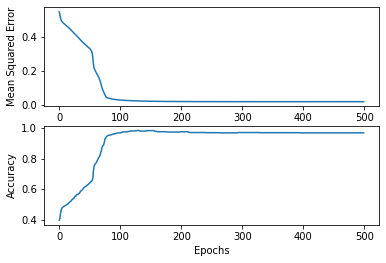

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.058342761271950996
Classification Report
                             
TP                        189
TN                        214
FP                          5
FN                          3
Total                     411
Accuracy   0.9805352798053528
Recall               0.984375
Precision  0.9742268041237113


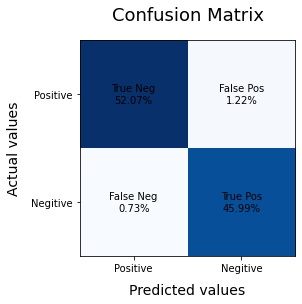

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.3569836013653957 Accuracy: 0.590625
Epoch: 50 Loss: 0.022265507422527996 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.017128789528830214 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.014533363965442199 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.01304723996100752 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.012138622222298272 Accuracy: 0.9895833333333334
Epoch: 300 Loss: 0.011550809386065649 Accuracy: 0.9895833333333334
Epoch: 350 Loss: 0.01114891122890535 Accuracy: 0.9895833333333334
Epoch: 400 Loss: 0.010860106731658358 Accuracy: 0.9916666666666667
Epoch: 450 Loss: 0.010643913610912374 Accuracy: 0.9916666666666667



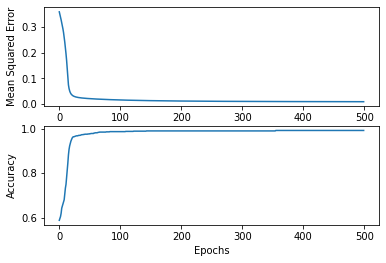

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3750187249460651
Classification Report
                             
TP                        180
TN                        229
FP                          2
FN                          0
Total                     411
Accuracy   0.9951338199513382
Recall                    1.0
Precision   0.989010989010989


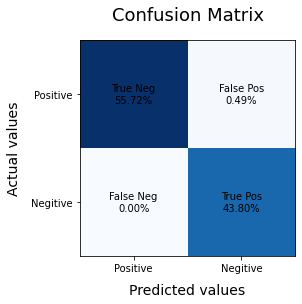

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.1823828723602493 Accuracy: 0.7760416666666666
Epoch: 50 Loss: 0.02599251733477838 Accuracy: 0.975
Epoch: 100 Loss: 0.02092226139619814 Accuracy: 0.9833333333333333
Epoch: 150 Loss: 0.0189795502004797 Accuracy: 0.98125
Epoch: 200 Loss: 0.01832209057426813 Accuracy: 0.984375
Epoch: 250 Loss: 0.018252225110477558 Accuracy: 0.9854166666666667
Epoch: 300 Loss: 0.01844403905498495 Accuracy: 0.9822916666666667
Epoch: 350 Loss: 0.018743477641494064 Accuracy: 0.9822916666666667
Epoch: 400 Loss: 0.01907994164495548 Accuracy: 0.9822916666666667
Epoch: 450 Loss: 0.019422042819117337 Accuracy: 0.9791666666666666



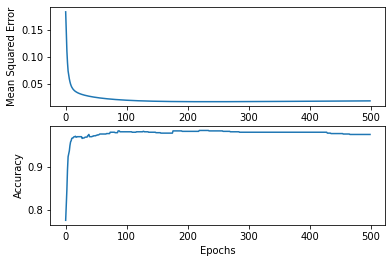

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.02499441882327433
Classification Report
                             
TP                        176
TN                        223
FP                          1
FN                         11
Total                     411
Accuracy   0.9708029197080292
Recall     0.9411764705882353
Precision  0.9943502824858758


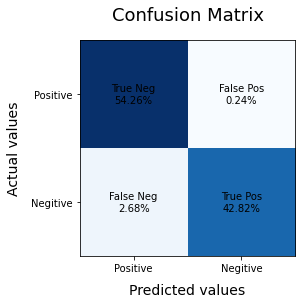

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.3308926135735591 Accuracy: 0.5604166666666667
Epoch: 50 Loss: 0.034311642412035145 Accuracy: 0.9572916666666667
Epoch: 100 Loss: 0.026423654489418896 Accuracy: 0.9729166666666667
Epoch: 150 Loss: 0.023221904337045424 Accuracy: 0.9802083333333333
Epoch: 200 Loss: 0.021599892384365937 Accuracy: 0.98125
Epoch: 250 Loss: 0.02071914502839285 Accuracy: 0.9739583333333334
Epoch: 300 Loss: 0.020224080453951184 Accuracy: 0.971875
Epoch: 350 Loss: 0.019943513432933654 Accuracy: 0.971875
Epoch: 400 Loss: 0.0197887731207053 Accuracy: 0.971875
Epoch: 450 Loss: 0.019710913821129473 Accuracy: 0.971875



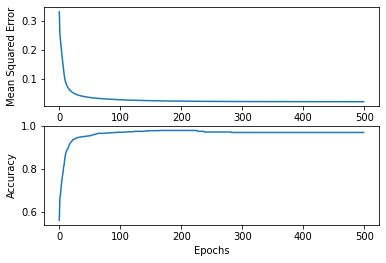

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.6261266115359361
Classification Report
                             
TP                        180
TN                        220
FP                         11
FN                          0
Total                     411
Accuracy   0.9732360097323601
Recall                    1.0
Precision  0.9424083769633508


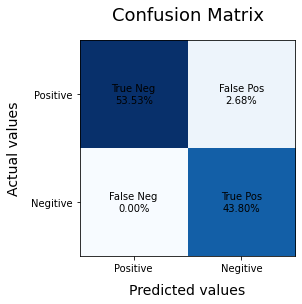

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.14059908777833557 Accuracy: 0.7989583333333333
Epoch: 50 Loss: 0.022758509612538273 Accuracy: 0.9760416666666667
Epoch: 100 Loss: 0.016377155163479238 Accuracy: 0.9875
Epoch: 150 Loss: 0.013877413763591178 Accuracy: 0.9875
Epoch: 200 Loss: 0.012602148912202201 Accuracy: 0.9875
Epoch: 250 Loss: 0.01183539079892979 Accuracy: 0.9885416666666667
Epoch: 300 Loss: 0.011323869333221484 Accuracy: 0.9895833333333334
Epoch: 350 Loss: 0.010960644899368762 Accuracy: 0.9895833333333334
Epoch: 400 Loss: 0.010692755216311257 Accuracy: 0.9895833333333334
Epoch: 450 Loss: 0.010490328404055916 Accuracy: 0.9895833333333334



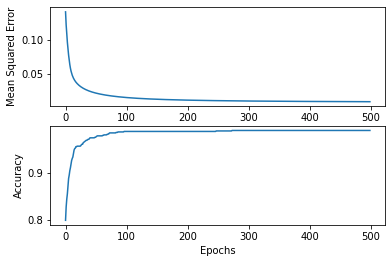

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.2616016047047629
Classification Report
                             
TP                        183
TN                        225
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9838709677419355


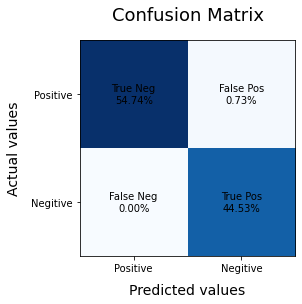

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.5388453724390173 Accuracy: 0.41770833333333335
Epoch: 50 Loss: 0.03382116703934958 Accuracy: 0.95625
Epoch: 100 Loss: 0.015511401376880724 Accuracy: 0.9916666666666667
Epoch: 150 Loss: 0.011652909754847255 Accuracy: 0.9895833333333334
Epoch: 200 Loss: 0.010546049996569808 Accuracy: 0.990625
Epoch: 250 Loss: 0.010011553463847273 Accuracy: 0.9885416666666667
Epoch: 300 Loss: 0.009674637940543795 Accuracy: 0.9885416666666667
Epoch: 350 Loss: 0.009440999120203903 Accuracy: 0.9885416666666667
Epoch: 400 Loss: 0.009271426617947675 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.00914457499689019 Accuracy: 0.9885416666666667



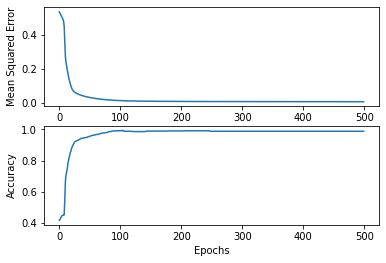

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.040656844990987505
Classification Report
                             
TP                        175
TN                        232
FP                          4
FN                          0
Total                     411
Accuracy   0.9902676399026764
Recall                    1.0
Precision  0.9776536312849162


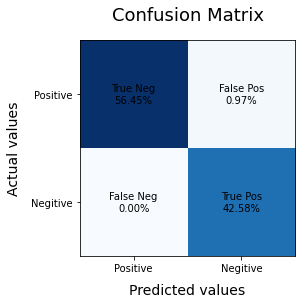

Final Classification Report
                             
TP                      180.9
TN                      222.5
FP                        6.0
FN                        1.6
Total                   411.0
Accuracy   0.9815085158150852
Recall     0.9914418368163693
Precision  0.9684325468930679


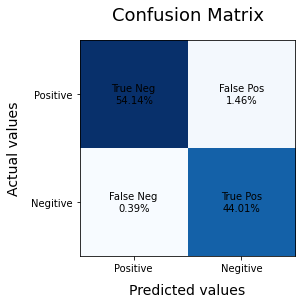

In [54]:
MBSGD.cross_val(10, learning='MBSGD', epochs=500, learning_rate=0.015, batch_size=10)

### Learning Rate = 0.1, Epochs = 500, Batch_size = 10 - Accuracy = 97.95% - Standaradized

In [66]:
MBSGD1 = LogReg(df, standardize = True)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.06798749626157538 Accuracy: 0.90625
Epoch: 50 Loss: 0.008488283693730874 Accuracy: 0.9916666666666667
Epoch: 100 Loss: 0.008579806755397691 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.008789381548704062 Accuracy: 0.9885416666666667
Epoch: 200 Loss: 0.008887509020561794 Accuracy: 0.9885416666666667
Epoch: 250 Loss: 0.008933500035765684 Accuracy: 0.9885416666666667
Epoch: 300 Loss: 0.008958958506167273 Accuracy: 0.9885416666666667
Epoch: 350 Loss: 0.008976128767682723 Accuracy: 0.9885416666666667
Epoch: 400 Loss: 0.008989683917219682 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.009001473968410365 Accuracy: 0.9885416666666667



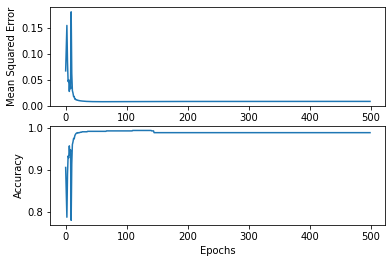

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.3423164038278643
Classification Report
                             
TP                        170
TN                        230
FP                         10
FN                          1
Total                     411
Accuracy   0.9732360097323601
Recall     0.9941520467836257
Precision  0.9444444444444444


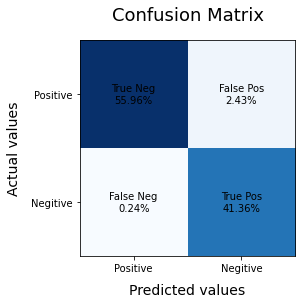

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.06587890946451944 Accuracy: 0.903125
Epoch: 50 Loss: 0.011322362842082339 Accuracy: 0.9916666666666667
Epoch: 100 Loss: 0.00948891059566287 Accuracy: 0.9927083333333333
Epoch: 150 Loss: 0.009014279546078486 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.008811024205472428 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.008713018366158188 Accuracy: 0.9916666666666667
Epoch: 300 Loss: 0.008666192129601256 Accuracy: 0.990625
Epoch: 350 Loss: 0.00864762272391475 Accuracy: 0.990625
Epoch: 400 Loss: 0.008645896750076116 Accuracy: 0.990625
Epoch: 450 Loss: 0.008654692473890713 Accuracy: 0.990625



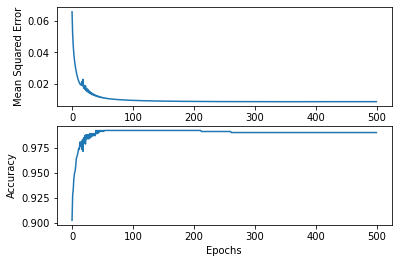

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5342298956038881
Classification Report
                             
TP                        192
TN                        215
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9948186528497409
Precision  0.9846153846153847


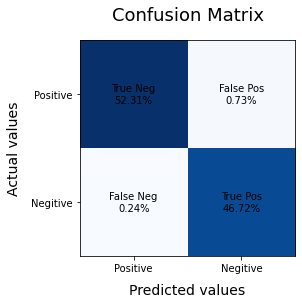

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.22453609797320417 Accuracy: 0.725
Epoch: 50 Loss: 0.015300862680707409 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.01058065306398881 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.010825420423885835 Accuracy: 0.990625
Epoch: 200 Loss: 0.010858238926080253 Accuracy: 0.990625
Epoch: 250 Loss: 0.010882116367720886 Accuracy: 0.9895833333333334
Epoch: 300 Loss: 0.010903999878208982 Accuracy: 0.9895833333333334
Epoch: 350 Loss: 0.01092590756531004 Accuracy: 0.9895833333333334
Epoch: 400 Loss: 0.010948181196793336 Accuracy: 0.9895833333333334
Epoch: 450 Loss: 0.010970557739315786 Accuracy: 0.9895833333333334



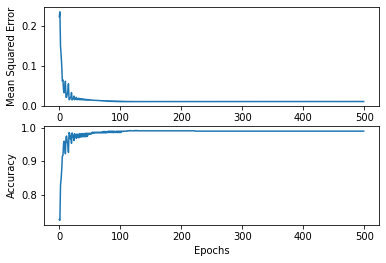

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.6596879088692498
Classification Report
                             
TP                        169
TN                        231
FP                          3
FN                          8
Total                     411
Accuracy   0.9732360097323601
Recall     0.9548022598870056
Precision  0.9825581395348837


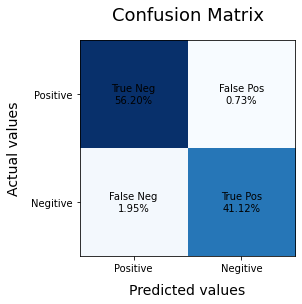

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.1342969343296656 Accuracy: 0.8416666666666667
Epoch: 50 Loss: 0.007747843199112387 Accuracy: 0.9927083333333333
Epoch: 100 Loss: 0.008018039593078768 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.008289009346467808 Accuracy: 0.9854166666666667
Epoch: 200 Loss: 0.008472168620195904 Accuracy: 0.9854166666666667
Epoch: 250 Loss: 0.008598644633821368 Accuracy: 0.9854166666666667
Epoch: 300 Loss: 0.008691593425412933 Accuracy: 0.9854166666666667
Epoch: 350 Loss: 0.008764173548559295 Accuracy: 0.9854166666666667
Epoch: 400 Loss: 0.008823766619057673 Accuracy: 0.9854166666666667
Epoch: 450 Loss: 0.008874645521293132 Accuracy: 0.9854166666666667



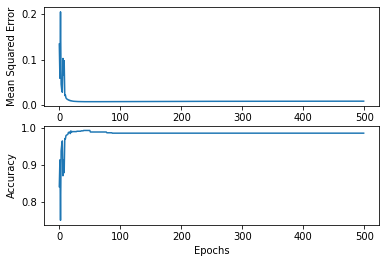

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.23438170115127302
Classification Report
                             
TP                        177
TN                        222
FP                         11
FN                          1
Total                     411
Accuracy   0.9708029197080292
Recall     0.9943820224719101
Precision  0.9414893617021277


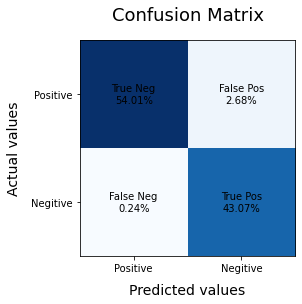

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.2490114689683354 Accuracy: 0.7166666666666667
Epoch: 50 Loss: 0.010603649679506706 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.008629476253320691 Accuracy: 0.9875
Epoch: 150 Loss: 0.008024428528275163 Accuracy: 0.9875
Epoch: 200 Loss: 0.007736721090022319 Accuracy: 0.9875
Epoch: 250 Loss: 0.0075671458258419234 Accuracy: 0.9875
Epoch: 300 Loss: 0.007454345429630692 Accuracy: 0.9864583333333333
Epoch: 350 Loss: 0.007373342614243729 Accuracy: 0.9864583333333333
Epoch: 400 Loss: 0.00731207087924014 Accuracy: 0.9864583333333333
Epoch: 450 Loss: 0.007263984563805256 Accuracy: 0.9864583333333333



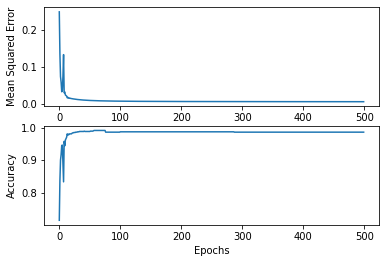

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.39286762465319996
Classification Report
                             
TP                        181
TN                        222
FP                          3
FN                          5
Total                     411
Accuracy   0.9805352798053528
Recall     0.9731182795698925
Precision  0.9836956521739131


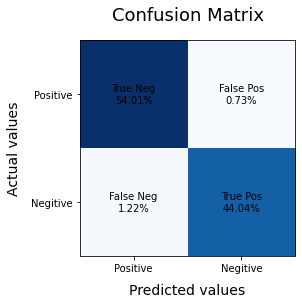

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.09637292630731453 Accuracy: 0.8552083333333333
Epoch: 50 Loss: 0.01704528486383691 Accuracy: 0.975
Epoch: 100 Loss: 0.021144564064343955 Accuracy: 0.9697916666666667
Epoch: 150 Loss: 0.014229595499854506 Accuracy: 0.98125
Epoch: 200 Loss: 0.011578860725446635 Accuracy: 0.984375
Epoch: 250 Loss: 0.011957488620822392 Accuracy: 0.9864583333333333
Epoch: 300 Loss: 0.012389188794970257 Accuracy: 0.9854166666666667
Epoch: 350 Loss: 0.012371025930852443 Accuracy: 0.9854166666666667
Epoch: 400 Loss: 0.012353252977580324 Accuracy: 0.9854166666666667
Epoch: 450 Loss: 0.012336814717755887 Accuracy: 0.9854166666666667



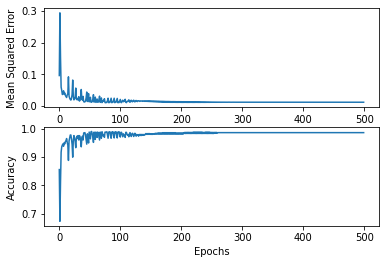

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.3640992256306587
Classification Report
                             
TP                        184
TN                        225
FP                          0
FN                          2
Total                     411
Accuracy   0.9951338199513382
Recall      0.989247311827957
Precision                 1.0


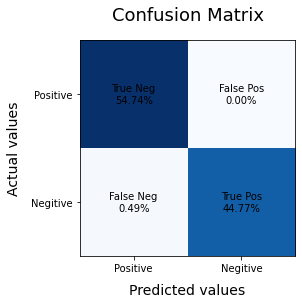

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.5347568342702134 Accuracy: 0.3416666666666667
Epoch: 50 Loss: 0.012575516898098969 Accuracy: 0.9885416666666667
Epoch: 100 Loss: 0.010559430926991253 Accuracy: 0.990625
Epoch: 150 Loss: 0.009780329593182492 Accuracy: 0.990625
Epoch: 200 Loss: 0.009367020335988196 Accuracy: 0.990625
Epoch: 250 Loss: 0.009115031028776312 Accuracy: 0.990625
Epoch: 300 Loss: 0.008950093300638616 Accuracy: 0.990625
Epoch: 350 Loss: 0.008838487833194898 Accuracy: 0.990625
Epoch: 400 Loss: 0.008762481157838198 Accuracy: 0.990625
Epoch: 450 Loss: 0.008711686218721346 Accuracy: 0.990625



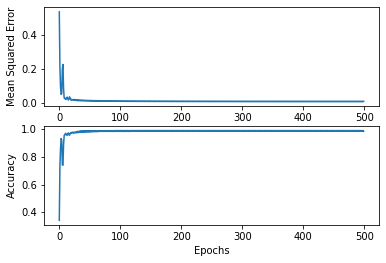

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.8269132390629438
Classification Report
                             
TP                        188
TN                        218
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9947089947089947
Precision  0.9791666666666666


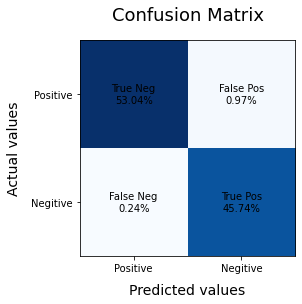

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.24249897519644276 Accuracy: 0.7145833333333333
Epoch: 50 Loss: 0.010809795312852246 Accuracy: 0.9895833333333334
Epoch: 100 Loss: 0.009426057819165952 Accuracy: 0.990625
Epoch: 150 Loss: 0.008946246869540786 Accuracy: 0.990625
Epoch: 200 Loss: 0.008690392575173048 Accuracy: 0.9927083333333333
Epoch: 250 Loss: 0.008525511822591451 Accuracy: 0.9927083333333333
Epoch: 300 Loss: 0.008407295849893566 Accuracy: 0.9927083333333333
Epoch: 350 Loss: 0.008316798287418962 Accuracy: 0.9927083333333333
Epoch: 400 Loss: 0.008244516491713087 Accuracy: 0.9895833333333334
Epoch: 450 Loss: 0.008185103875485761 Accuracy: 0.9895833333333334



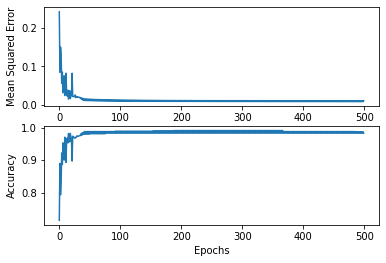

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.7434999015367186
Classification Report
                             
TP                        181
TN                        224
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9836956521739131
Precision  0.9836956521739131


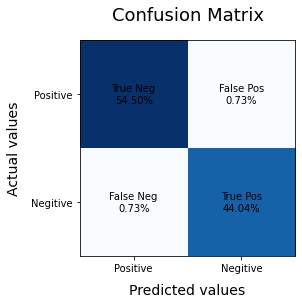

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.4419235755646204 Accuracy: 0.525
Epoch: 50 Loss: 0.009243951500957548 Accuracy: 0.990625
Epoch: 100 Loss: 0.013462268953370715 Accuracy: 0.9822916666666667
Epoch: 150 Loss: 0.013060460390998084 Accuracy: 0.98125
Epoch: 200 Loss: 0.012956374696403528 Accuracy: 0.9802083333333333
Epoch: 250 Loss: 0.012944427152478798 Accuracy: 0.9802083333333333
Epoch: 300 Loss: 0.012967312418104969 Accuracy: 0.9802083333333333
Epoch: 350 Loss: 0.013004465453387976 Accuracy: 0.9802083333333333
Epoch: 400 Loss: 0.013047307978176503 Accuracy: 0.9802083333333333
Epoch: 450 Loss: 0.013091920007457836 Accuracy: 0.9802083333333333



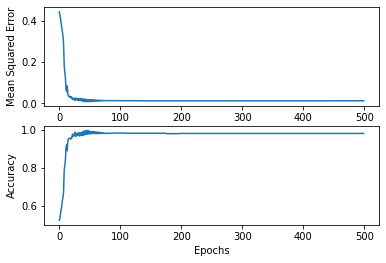

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.14110019624297418
Classification Report
                             
TP                        177
TN                        219
FP                          9
FN                          6
Total                     411
Accuracy   0.9635036496350365
Recall     0.9672131147540983
Precision  0.9516129032258065


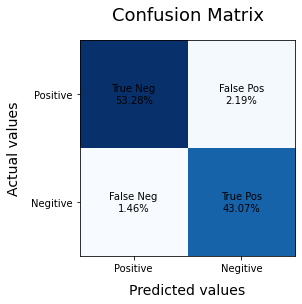

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.39473211334240793 Accuracy: 0.5645833333333333
Epoch: 50 Loss: 0.018764591789144292 Accuracy: 0.9791666666666666
Epoch: 100 Loss: 0.015426468689521005 Accuracy: 0.9822916666666667
Epoch: 150 Loss: 0.014161922891606128 Accuracy: 0.9833333333333333
Epoch: 200 Loss: 0.0135642262964777 Accuracy: 0.9822916666666667
Epoch: 250 Loss: 0.013232955989495277 Accuracy: 0.9822916666666667
Epoch: 300 Loss: 0.01302912334224458 Accuracy: 0.9822916666666667
Epoch: 350 Loss: 0.01289474759499821 Accuracy: 0.9822916666666667
Epoch: 400 Loss: 0.012801869679483992 Accuracy: 0.9822916666666667
Epoch: 450 Loss: 0.012735485609429014 Accuracy: 0.9822916666666667



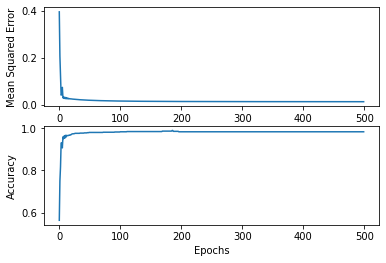

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.8873422495961246
Classification Report
                             
TP                        180
TN                        221
FP                         10
FN                          0
Total                     411
Accuracy    0.975669099756691
Recall                    1.0
Precision  0.9473684210526315


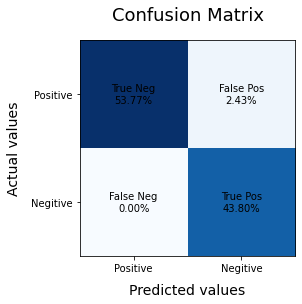

Final Classification Report
                             
TP                      179.9
TN                      222.7
FP                        5.6
FN                        2.8
Total                   411.0
Accuracy   0.9795620437956206
Recall     0.9846138335027137
Precision  0.9698646625589772


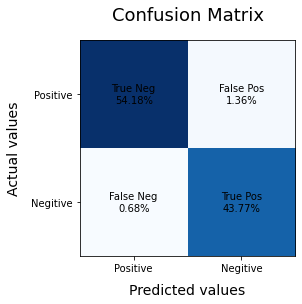

In [67]:
MBSGD1.cross_val(10, learning='MBSGD', epochs=500, learning_rate=0.1, batch_size=10)

### Learning Rate = 0.5, Epochs = 500, Batch_size = 10 - Accuracy = 97.71% - Standaradized

In [70]:
MBSGD2 = LogReg(df, standardize=True)

Total of 10 Splits:
Split 1 : 
Training the Model...


Epoch: 0 Loss: 0.5174825012791576 Accuracy: 0.47604166666666664
Epoch: 50 Loss: 0.008711094089940185 Accuracy: 0.990625
Epoch: 100 Loss: 0.018046555156218114 Accuracy: 0.9760416666666667
Epoch: 150 Loss: 0.018181571280905508 Accuracy: 0.978125
Epoch: 200 Loss: 0.018273127911459238 Accuracy: 0.978125
Epoch: 250 Loss: 0.018353721872650292 Accuracy: 0.978125
Epoch: 300 Loss: 0.018427644741886465 Accuracy: 0.9770833333333333
Epoch: 350 Loss: 0.018495710273641976 Accuracy: 0.9770833333333333
Epoch: 400 Loss: 0.018558467345662872 Accuracy: 0.9770833333333333
Epoch: 450 Loss: 0.01861643557139243 Accuracy: 0.9770833333333333



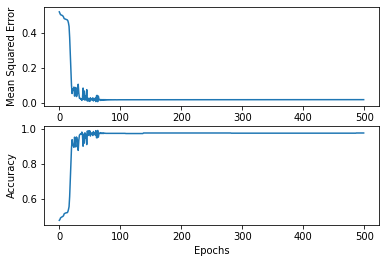

Trained the Model.
The most important feature is 'attr 3 ' with weight 0.12392849908447698
Classification Report
                             
TP                        180
TN                        218
FP                          1
FN                         12
Total                     411
Accuracy   0.9683698296836983
Recall                 0.9375
Precision   0.994475138121547


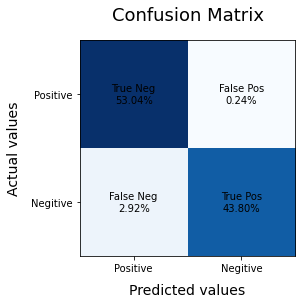

Split 2 : 
Training the Model...


Epoch: 0 Loss: 0.14446120388615963 Accuracy: 0.834375
Epoch: 50 Loss: 0.00746670401588445 Accuracy: 0.99375
Epoch: 100 Loss: 0.007433160900762675 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.007822603329118513 Accuracy: 0.9875
Epoch: 200 Loss: 0.008006082217229236 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.007650484829523628 Accuracy: 0.9895833333333334
Epoch: 300 Loss: 0.011668161316264632 Accuracy: 0.9864583333333333
Epoch: 350 Loss: 0.01296656295231834 Accuracy: 0.9854166666666667
Epoch: 400 Loss: 0.009440906409981138 Accuracy: 0.9885416666666667
Epoch: 450 Loss: 0.007893950910360204 Accuracy: 0.9895833333333334



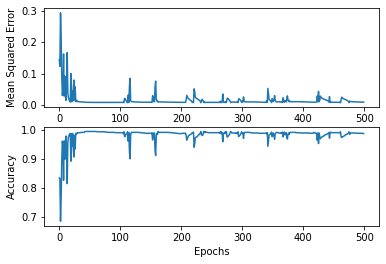

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.4907404631298085
Classification Report
                             
TP                        190
TN                        215
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9895833333333334
Precision   0.979381443298969


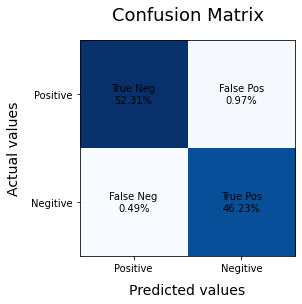

Split 3 : 
Training the Model...


Epoch: 0 Loss: 0.32098213263505027 Accuracy: 0.671875
Epoch: 50 Loss: 0.017607684369603072 Accuracy: 0.978125
Epoch: 100 Loss: 0.009095268806971145 Accuracy: 0.9895833333333334
Epoch: 150 Loss: 0.008415623237406357 Accuracy: 0.9927083333333333
Epoch: 200 Loss: 0.00829520786581766 Accuracy: 0.9895833333333334
Epoch: 250 Loss: 0.008349785081111071 Accuracy: 0.9895833333333334
Epoch: 300 Loss: 0.00847050573102712 Accuracy: 0.9895833333333334
Epoch: 350 Loss: 0.008616571776622957 Accuracy: 0.9895833333333334
Epoch: 400 Loss: 0.008770608142148407 Accuracy: 0.9854166666666667
Epoch: 450 Loss: 0.008924716569679346 Accuracy: 0.9854166666666667



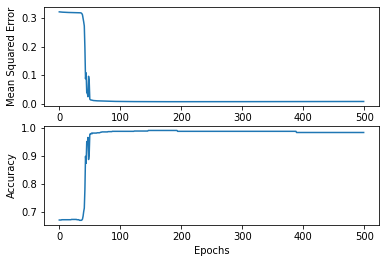

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.5980244601460507
Classification Report
                             
TP                        173
TN                        232
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9829545454545454
Precision  0.9829545454545454


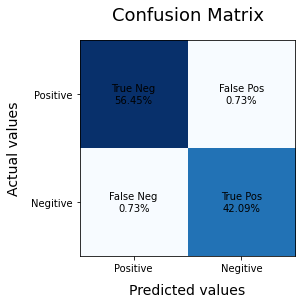

Split 4 : 
Training the Model...


Epoch: 0 Loss: 0.07525993434254849 Accuracy: 0.9072916666666667
Epoch: 50 Loss: 0.0157611138604979 Accuracy: 0.9802083333333333
Epoch: 100 Loss: 0.014372307269219288 Accuracy: 0.9822916666666667
Epoch: 150 Loss: 0.013403493109163247 Accuracy: 0.9822916666666667
Epoch: 200 Loss: 0.012467463336895608 Accuracy: 0.984375
Epoch: 250 Loss: 0.01158853533494058 Accuracy: 0.984375
Epoch: 300 Loss: 0.0109880287612559 Accuracy: 0.9875
Epoch: 350 Loss: 0.010668796021759689 Accuracy: 0.9875
Epoch: 400 Loss: 0.01051532898499058 Accuracy: 0.9875
Epoch: 450 Loss: 0.01044253201363365 Accuracy: 0.9875



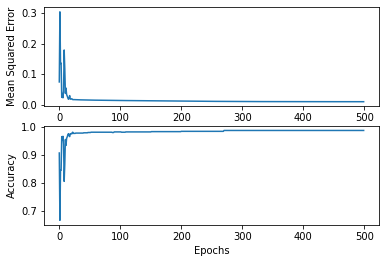

Trained the Model.
The most important feature is 'attr 3 ' with weight -2.3468368431827193
Classification Report
                             
TP                        188
TN                        219
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9947089947089947
Precision  0.9842931937172775


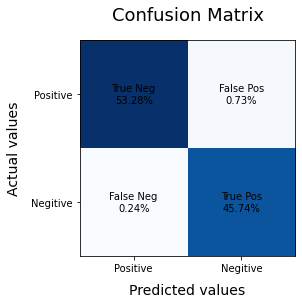

Split 5 : 
Training the Model...


Epoch: 0 Loss: 0.08210899770327122 Accuracy: 0.9041666666666667
Epoch: 50 Loss: 0.010616657815953745 Accuracy: 0.9833333333333333
Epoch: 100 Loss: 0.010014175527725046 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.00982082908242152 Accuracy: 0.9864583333333333
Epoch: 200 Loss: 0.00973123060176853 Accuracy: 0.9864583333333333
Epoch: 250 Loss: 0.009676938813783936 Accuracy: 0.9864583333333333
Epoch: 300 Loss: 0.009636684980424625 Accuracy: 0.9864583333333333
Epoch: 350 Loss: 0.009602790768920373 Accuracy: 0.9864583333333333
Epoch: 400 Loss: 0.009572184179715932 Accuracy: 0.9864583333333333
Epoch: 450 Loss: 0.00954355265860596 Accuracy: 0.9864583333333333



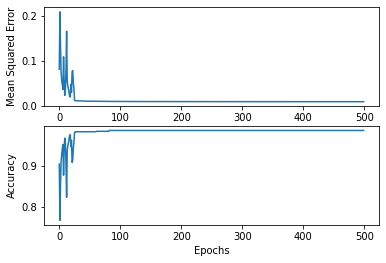

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.38916731543899313
Classification Report
                             
TP                        177
TN                        225
FP                          2
FN                          7
Total                     411
Accuracy   0.9781021897810219
Recall     0.9619565217391305
Precision  0.9888268156424581


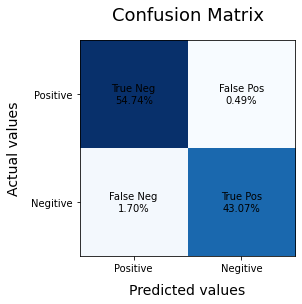

Split 6 : 
Training the Model...


Epoch: 0 Loss: 0.14913899199058994 Accuracy: 0.8260416666666667
Epoch: 50 Loss: 0.02003711135671801 Accuracy: 0.9760416666666667
Epoch: 100 Loss: 0.03357227207718303 Accuracy: 0.9645833333333333
Epoch: 150 Loss: 0.028546712875667644 Accuracy: 0.9666666666666667
Epoch: 200 Loss: 0.024083093694079405 Accuracy: 0.975
Epoch: 250 Loss: 0.009141915040423724 Accuracy: 0.9916666666666667
Epoch: 300 Loss: 0.008240005647549136 Accuracy: 0.99375
Epoch: 350 Loss: 0.01839667691023663 Accuracy: 0.978125
Epoch: 400 Loss: 0.01035479051572057 Accuracy: 0.984375
Epoch: 450 Loss: 0.009264212747111563 Accuracy: 0.9895833333333334



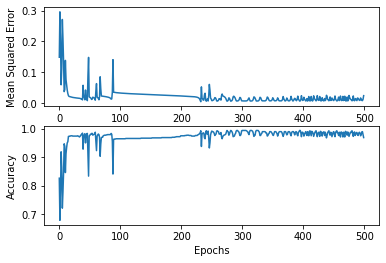

Trained the Model.
The most important feature is 'attr 3 ' with weight -0.4559950074890408
Classification Report
                             
TP                        172
TN                        216
FP                          7
FN                         16
Total                     411
Accuracy   0.9440389294403893
Recall     0.9148936170212766
Precision  0.9608938547486033


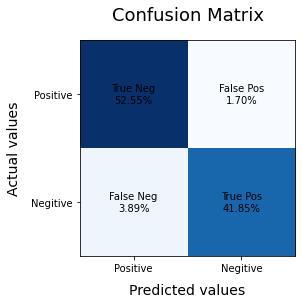

Split 7 : 
Training the Model...


Epoch: 0 Loss: 0.35410433708297734 Accuracy: 0.6333333333333333
Epoch: 50 Loss: 0.02976180420136552 Accuracy: 0.9614583333333333
Epoch: 100 Loss: 0.018014342243096358 Accuracy: 0.9802083333333333
Epoch: 150 Loss: 0.017755889695909112 Accuracy: 0.98125
Epoch: 200 Loss: 0.02898594180817548 Accuracy: 0.9666666666666667
Epoch: 250 Loss: 0.018604463134522208 Accuracy: 0.9791666666666666
Epoch: 300 Loss: 0.020858889680402417 Accuracy: 0.978125
Epoch: 350 Loss: 0.015797703067652647 Accuracy: 0.9833333333333333
Epoch: 400 Loss: 0.01842065306563852 Accuracy: 0.9802083333333333
Epoch: 450 Loss: 0.01911262915992209 Accuracy: 0.9770833333333333



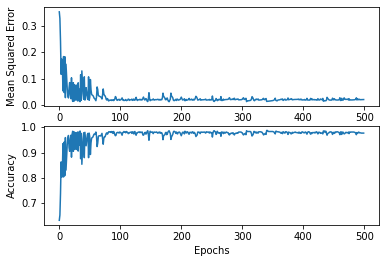

Trained the Model.
The most important feature is 'attr 3 ' with weight -3.316232098703635
Classification Report
                             
TP                        174
TN                        224
FP                         12
FN                          1
Total                     411
Accuracy   0.9683698296836983
Recall     0.9942857142857143
Precision  0.9354838709677419


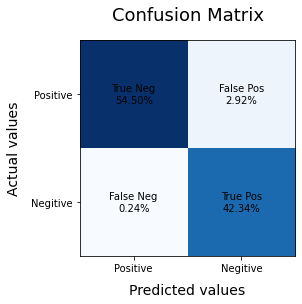

Split 8 : 
Training the Model...


Epoch: 0 Loss: 0.22750455575327305 Accuracy: 0.75
Epoch: 50 Loss: 0.020408520160629034 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.012761993334846018 Accuracy: 0.9854166666666667
Epoch: 150 Loss: 0.024467374777800248 Accuracy: 0.9697916666666667
Epoch: 200 Loss: 0.020902444925808873 Accuracy: 0.971875
Epoch: 250 Loss: 0.017352018557053213 Accuracy: 0.9791666666666666
Epoch: 300 Loss: 0.019163555780441308 Accuracy: 0.9770833333333333
Epoch: 350 Loss: 0.019823374190817693 Accuracy: 0.9760416666666667
Epoch: 400 Loss: 0.019990727312453608 Accuracy: 0.9760416666666667
Epoch: 450 Loss: 0.020126536365882648 Accuracy: 0.9739583333333334



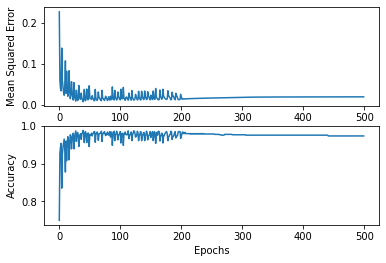

Trained the Model.
The most important feature is 'attr 3 ' with weight 1.5542666125373978
Classification Report
                             
TP                        182
TN                        222
FP                          2
FN                          5
Total                     411
Accuracy   0.9829683698296837
Recall     0.9732620320855615
Precision  0.9891304347826086


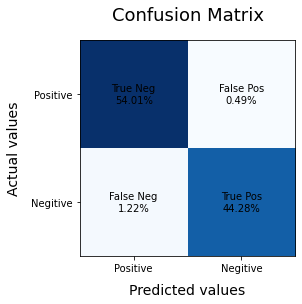

Split 9 : 
Training the Model...


Epoch: 0 Loss: 0.09404147525894062 Accuracy: 0.878125
Epoch: 50 Loss: 0.02663348733163835 Accuracy: 0.9697916666666667
Epoch: 100 Loss: 0.01180602136831795 Accuracy: 0.9864583333333333
Epoch: 150 Loss: 0.02962794886847436 Accuracy: 0.9666666666666667
Epoch: 200 Loss: 0.02740616164553489 Accuracy: 0.9645833333333333
Epoch: 250 Loss: 0.014156329367503828 Accuracy: 0.9833333333333333
Epoch: 300 Loss: 0.012242225586892847 Accuracy: 0.9864583333333333
Epoch: 350 Loss: 0.011121637363143203 Accuracy: 0.9875
Epoch: 400 Loss: 0.013890390176089168 Accuracy: 0.984375
Epoch: 450 Loss: 0.01360354822487789 Accuracy: 0.984375



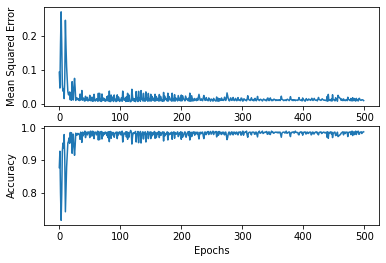

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.1760819649269694
Classification Report
                             
TP                        190
TN                        219
FP                          1
FN                          1
Total                     411
Accuracy   0.9951338199513382
Recall     0.9947643979057592
Precision  0.9947643979057592


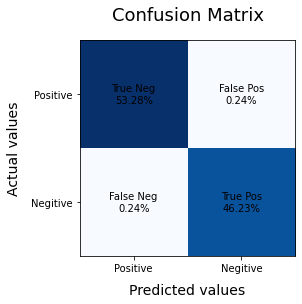

Split 10 : 
Training the Model...


Epoch: 0 Loss: 0.2164141484916647 Accuracy: 0.7572916666666667
Epoch: 50 Loss: 0.027443397198815375 Accuracy: 0.9677083333333333
Epoch: 100 Loss: 0.02557917404826007 Accuracy: 0.96875
Epoch: 150 Loss: 0.024570218310761387 Accuracy: 0.96875
Epoch: 200 Loss: 0.023799065605509546 Accuracy: 0.9645833333333333
Epoch: 250 Loss: 0.023087121585000103 Accuracy: 0.9645833333333333
Epoch: 300 Loss: 0.02234103476056771 Accuracy: 0.9677083333333333
Epoch: 350 Loss: 0.02147633977538687 Accuracy: 0.9697916666666667
Epoch: 400 Loss: 0.02036935357080385 Accuracy: 0.9697916666666667
Epoch: 450 Loss: 0.018751777258493276 Accuracy: 0.9729166666666667



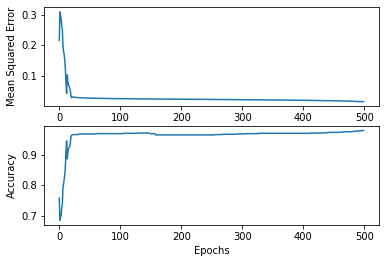

Trained the Model.
The most important feature is 'attr 3 ' with weight -1.034491830909649
Classification Report
                             
TP                        182
TN                        218
FP                          4
FN                          7
Total                     411
Accuracy   0.9732360097323601
Recall     0.9629629629629629
Precision   0.978494623655914


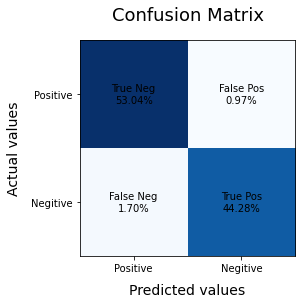

Final Classification Report
                             
TP                      180.8
TN                      220.8
FP                        3.9
FN                        5.5
Total                   411.0
Accuracy   0.9771289537712897
Recall     0.9706872119497281
Precision  0.9788698318295423


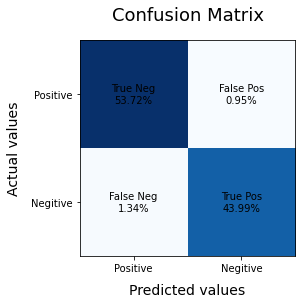

In [71]:
MBSGD2.cross_val(10, learning='MBSGD', epochs=500, learning_rate=0.5, batch_size=10)